In [1]:
!pip install mne

In [2]:
!git clone https://github.com/sagihaider/EEG_Deep.git

Cloning into 'EEG_Deep'...
remote: Enumerating objects: 529, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 529 (delta 29), reused 0 (delta 0), pack-reused 477
Receiving objects: 100% (529/529), 1.69 GiB | 12.13 MiB/s, done.
Resolving deltas: 100% (259/259), done.
Updating files: 100% (95/95), done.


In [2]:
import numpy as np
import pandas as pd
import mne
from mne import read_epochs
from mne import pick_types, Epochs
from mne.channels import read_layout
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score


# EEGNet-specific imports
from EEG_Deep.EEGModels import EEGNet, ShallowConvNet, DeepConvNet, EEGNet_Patient
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
import tensorflow as tf

In [3]:
# Initialize parameters
# d = 0.25 # static
# kl = 64 # static, tried 32, 64, 128
# if loop,
# Define the values of kl and d to iterate over
kl_values = [8,16,32,64,128]
d_values = [0.2, 0.25, 0.5]

n_epochs = 200

out_f_name = '/content/drive/MyDrive/MEG/' +'acc_EEGNet' + '_epochs_' + str(n_epochs) + '_filter_' + '_ReniData.npy'
print(out_f_name)

nsub = 1

# Define the event pairs and time window for epoching
event_id = {'hand_imagery': 4, 'feet_imagery': 8, 'subtraction_imagery': 16, 'word_imagery': 32}
event_pairs = [('hand_imagery', 'feet_imagery'), ('hand_imagery', 'subtraction_imagery'), ('hand_imagery', 'word_imagery'), ('feet_imagery', 'subtraction_imagery'),
               ('feet_imagery', 'word_imagery'), ('subtraction_imagery', 'word_imagery')]

/content/drive/MyDrive/MEG/acc_EEGNet_epochs_200_filter__ReniData.npy


# SUBJECT 1, 3, 6, 7, 15, 19

In [4]:
epoch_path_train = '/content/drive/MyDrive/MEG/Artifact Corrected Notch Filtered Bandpass Filtered (2s-6s)/sub_19_ses_1_epochs-epo.fif'
epoch_path_test  = '/content/drive/MyDrive/MEG/Artifact Corrected Notch Filtered Bandpass Filtered (2s-6s)/sub_19_ses_2_filtered_epochs-epo.fif'

In [5]:
# Load the training epochs
epochs_train = mne.read_epochs(epoch_path_train)

# Load the testing epochs
epochs_test = mne.read_epochs(epoch_path_test)

# Select only gradiometer channels
grad_channels = mne.pick_types(epochs_train.info, meg='grad')
grad_channel_names = [epochs_train.ch_names[ch] for ch in grad_channels]
epochs_train = epochs_train.pick_channels(grad_channel_names)
epochs_test = epochs_test.pick_channels(grad_channel_names)

# Define the number of events you want to pick at a time
num_events_per_iteration = 2

# Get a list of all the unique event IDs
unique_event_ids = np.unique(epochs_train.events[:, -1])

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['Event Pair', 'AUC Score', 'kl', 'd'])

Reading /content/drive/MyDrive/MEG/Artifact Corrected Notch Filtered Bandpass Filtered (2s-6s)/sub_19_ses_1_epochs-epo.fif ...
    Read a total of 4 projection items:
        ECG-planar--0.200-0.400-PCA-01 (1 x 204) active
        ECG-axial--0.200-0.400-PCA-01 (1 x 102) active
        EOG-planar--0.200-0.200-PCA-01 (1 x 204) active
        EOG-axial--0.200-0.200-PCA-01 (1 x 102) active
    Found the data of interest:
        t =    2000.00 ...    6000.00 ms
        0 CTF compensation matrices available
Not setting metadata
200 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Reading /content/drive/MyDrive/MEG/Artifact Corrected Notch Filtered Bandpass Filtered (2s-6s)/sub_19_ses_2_filtered_epochs-epo.fif ...
    Read a total of 4 projection items:
        ECG-planar--0.200-0.400-PCA-01 (1 x 204) active
        ECG-axial--0.200-0.400-PCA-01 (1 x 102) active
        EOG-planar--0.200-0.200-PCA-01 (1 x 204) 

# **MEGNet**

Not setting metadata
100 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
Not setting metadata
100 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



y_train shape: (100, 2)
y_test shape: (100, 2)
X_train shape: (100, 1, 204, 2001)
X_test shape: (100, 1, 204, 2001)


Current kl: 8
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69210, saving model to /tmp/checkpoint.h5
5/5 - 12s - loss: 0.6894 - accuracy: 0.5500 - val_loss: 0.6921 - val_accuracy: 0.5500 - 12s/epoch - 2s/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69210
5/5 - 0s - loss: 0.5958 - accuracy: 0.7625 - val_loss: 0.6929 - val_accuracy: 0.5500 - 275ms/epoch - 55ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69210
5/5 - 0s - loss: 0.5191 - accuracy: 0.9250 - val_loss: 0.6943 - val_accuracy: 0.4000 - 274ms/epoch - 55ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69210
5/5 - 0s - loss: 0.4710 - accuracy: 0.9500 - val_loss: 0.6957 - val_accuracy: 0.4500 - 295ms/epoch - 59ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.69210
5/5 - 0s - loss: 0.4096 - accuracy: 0.9625 - val_loss: 0.6976 - val_accura

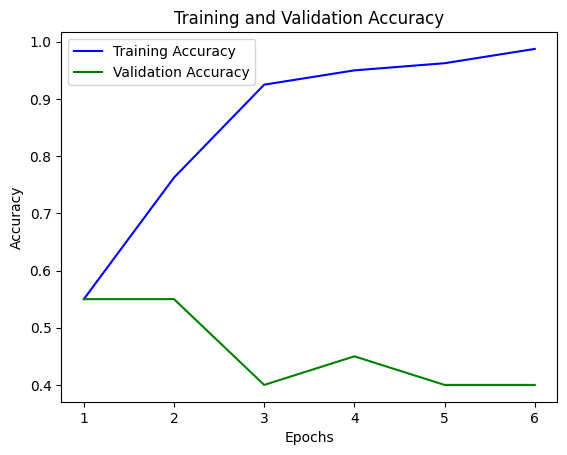


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6917 - accuracy: 0.5300
Test loss, Test accuracy: [0.6917222738265991, 0.5299999713897705]
4/4 [==============================] - 1s 25ms/step
AUC Accuracy Score: 0.5448



Current kl: 8
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69507, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.6834 - accuracy: 0.5750 - val_loss: 0.6951 - val_accuracy: 0.3500 - 4s/epoch - 701ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69507
5/5 - 0s - loss: 0.6339 - accuracy: 0.7500 - val_loss: 0.6959 - val_accuracy: 0.3000 - 306ms/epoch - 61ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69507
5/5 - 0s - loss: 0.5827 - accuracy: 0.7625 - val_loss: 0.6973 - val_accuracy: 0.3000 - 281ms/epoch - 56ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69507
5/5 - 0s - loss: 0.5387 - accuracy: 0.8375 - val_loss: 0.6985 - val_accuracy: 0.3500 - 280ms/epoch 

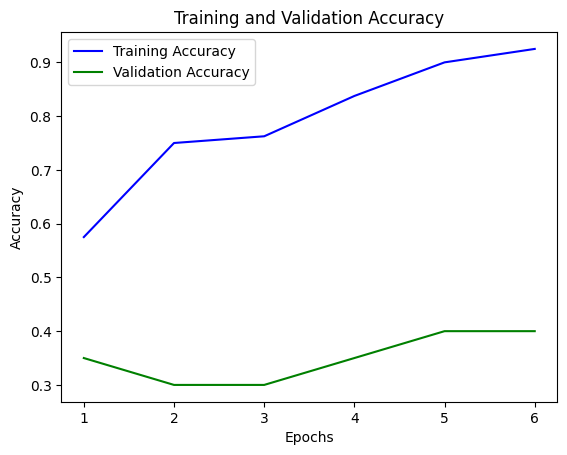


# Evaluate on test data
100/100 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.4900
Test loss, Test accuracy: [0.6928293704986572, 0.49000000953674316]
4/4 [==============================] - 0s 32ms/step
AUC Accuracy Score: 0.5292



Current kl: 8
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69798, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7611 - accuracy: 0.4000 - val_loss: 0.6980 - val_accuracy: 0.2500 - 3s/epoch - 567ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69798
5/5 - 0s - loss: 0.6573 - accuracy: 0.6500 - val_loss: 0.7006 - val_accuracy: 0.2500 - 354ms/epoch - 71ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69798
5/5 - 0s - loss: 0.5844 - accuracy: 0.7625 - val_loss: 0.7012 - val_accuracy: 0.3000 - 314ms/epoch - 63ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69798
5/5 - 0s - loss: 0.5439 - accuracy: 0.8250 - val_loss: 0.7027 - val_accuracy: 0.3000 - 321ms/epoch 

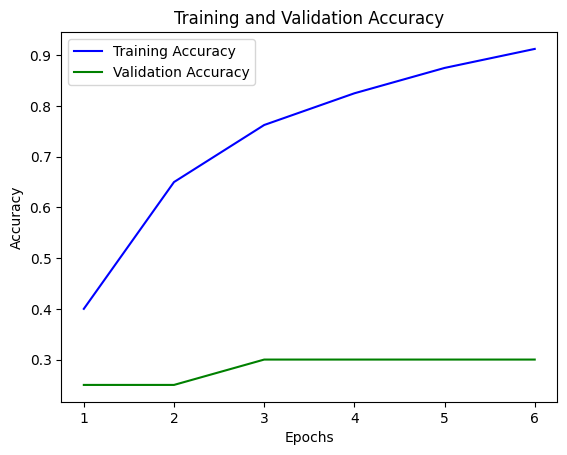


# Evaluate on test data
100/100 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.5600
Test loss, Test accuracy: [0.6882837414741516, 0.5600000023841858]
4/4 [==============================] - 0s 33ms/step
AUC Accuracy Score: 0.5835999999999999



Current kl: 16
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69289, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7513 - accuracy: 0.4500 - val_loss: 0.6929 - val_accuracy: 0.5000 - 4s/epoch - 702ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69289
5/5 - 0s - loss: 0.6263 - accuracy: 0.7750 - val_loss: 0.6939 - val_accuracy: 0.3500 - 307ms/epoch - 61ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69289
5/5 - 0s - loss: 0.5629 - accuracy: 0.8625 - val_loss: 0.6946 - val_accuracy: 0.3500 - 271ms/epoch - 54ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69289
5/5 - 0s - loss: 0.4902 - accuracy: 0.9750 - val_loss: 0.6956 - val_accuracy: 0.3500 - 

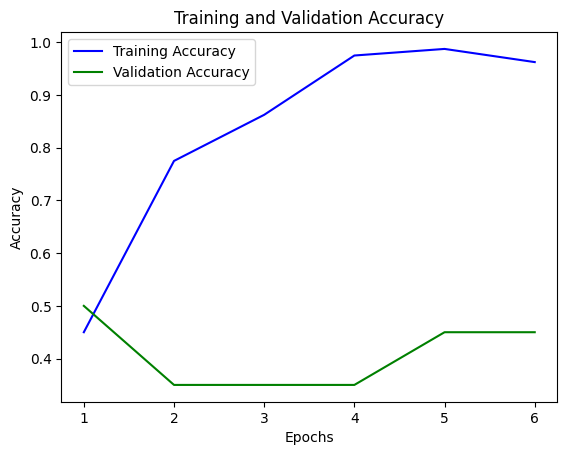


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6927 - accuracy: 0.4500
Test loss, Test accuracy: [0.6927157044410706, 0.44999998807907104]
4/4 [==============================] - 1s 31ms/step
AUC Accuracy Score: 0.5052



Current kl: 16
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69677, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.6792 - accuracy: 0.6125 - val_loss: 0.6968 - val_accuracy: 0.3000 - 4s/epoch - 711ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69677
5/5 - 0s - loss: 0.5863 - accuracy: 0.8625 - val_loss: 0.6996 - val_accuracy: 0.4500 - 296ms/epoch - 59ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69677
5/5 - 0s - loss: 0.5119 - accuracy: 0.8750 - val_loss: 0.7049 - val_accuracy: 0.4500 - 294ms/epoch - 59ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69677
5/5 - 0s - loss: 0.4558 - accuracy: 0.9125 - val_loss: 0.7101 - val_accuracy: 0.4000 - 297ms/epoc

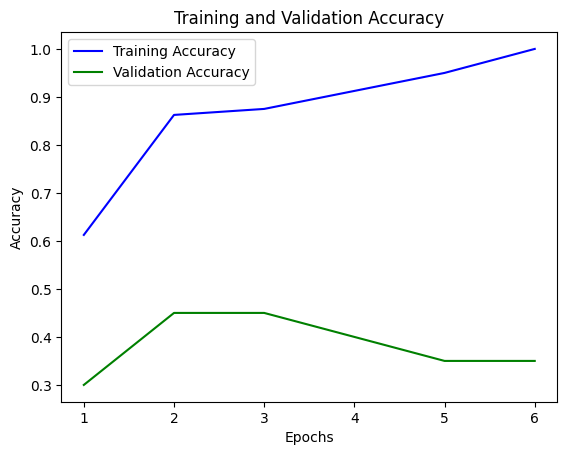


# Evaluate on test data
100/100 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5800
Test loss, Test accuracy: [0.6872114539146423, 0.5799999833106995]
4/4 [==============================] - 0s 30ms/step
AUC Accuracy Score: 0.5652



Current kl: 16
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69548, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7389 - accuracy: 0.4375 - val_loss: 0.6955 - val_accuracy: 0.2000 - 3s/epoch - 566ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69548
5/5 - 0s - loss: 0.6621 - accuracy: 0.6250 - val_loss: 0.6969 - val_accuracy: 0.2500 - 315ms/epoch - 63ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69548
5/5 - 0s - loss: 0.5926 - accuracy: 0.8250 - val_loss: 0.6984 - val_accuracy: 0.3000 - 274ms/epoch - 55ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69548
5/5 - 0s - loss: 0.5963 - accuracy: 0.7500 - val_loss: 0.6996 - val_accuracy: 0.3000 - 274ms/epoch 

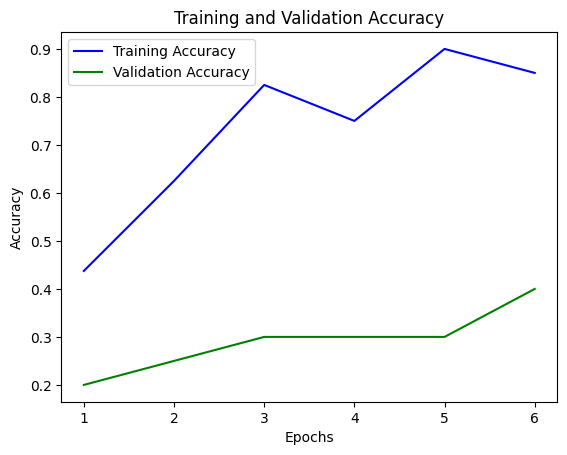


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6917 - accuracy: 0.5100
Test loss, Test accuracy: [0.6916530132293701, 0.5099999904632568]
4/4 [==============================] - 0s 44ms/step
AUC Accuracy Score: 0.5227999999999999



Current kl: 32
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69387, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7304 - accuracy: 0.4250 - val_loss: 0.6939 - val_accuracy: 0.4000 - 3s/epoch - 655ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69387
5/5 - 0s - loss: 0.6125 - accuracy: 0.7750 - val_loss: 0.6953 - val_accuracy: 0.4500 - 275ms/epoch - 55ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69387
5/5 - 0s - loss: 0.5555 - accuracy: 0.8125 - val_loss: 0.6964 - val_accuracy: 0.5000 - 284ms/epoch - 57ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69387
5/5 - 0s - loss: 0.5010 - accuracy: 0.8625 - val_loss: 0.6978 - val_accuracy: 0.5500 - 

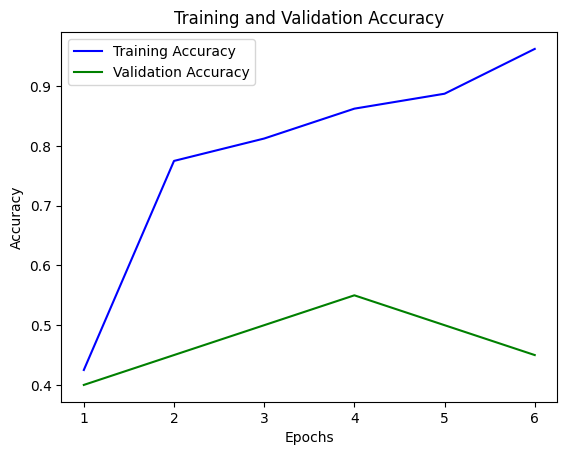


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6926 - accuracy: 0.5300
Test loss, Test accuracy: [0.692618191242218, 0.5299999713897705]
4/4 [==============================] - 1s 31ms/step
AUC Accuracy Score: 0.5136000000000001



Current kl: 32
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69179, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7229 - accuracy: 0.5500 - val_loss: 0.6918 - val_accuracy: 0.6000 - 4s/epoch - 817ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69179 to 0.69109, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6313 - accuracy: 0.7375 - val_loss: 0.6911 - val_accuracy: 0.5500 - 410ms/epoch - 82ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69109 to 0.69034, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5708 - accuracy: 0.8625 - val_loss: 0.6903 - val_accuracy: 0.4500 - 350ms/epoch - 70ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69034 to 0.68992, sa

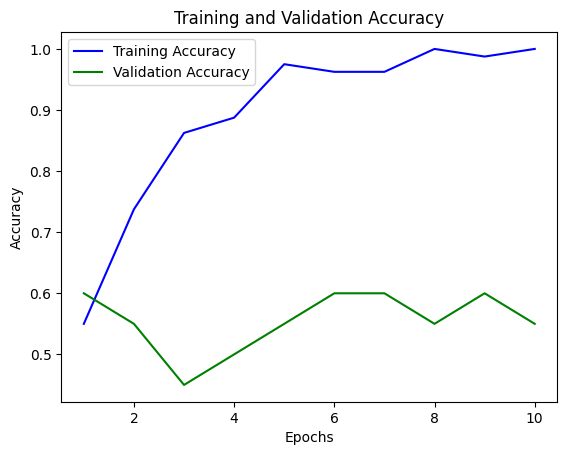


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6779 - accuracy: 0.5700
Test loss, Test accuracy: [0.67789626121521, 0.5699999928474426]
4/4 [==============================] - 0s 39ms/step
AUC Accuracy Score: 0.6396000000000001



Current kl: 32
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69120, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7311 - accuracy: 0.5125 - val_loss: 0.6912 - val_accuracy: 0.6000 - 4s/epoch - 758ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69120
5/5 - 0s - loss: 0.6750 - accuracy: 0.5750 - val_loss: 0.6927 - val_accuracy: 0.5500 - 352ms/epoch - 70ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69120
5/5 - 0s - loss: 0.6366 - accuracy: 0.6000 - val_loss: 0.6927 - val_accuracy: 0.4000 - 344ms/epoch - 69ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69120 to 0.69103, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5800 - accuracy: 0.8250 - val_

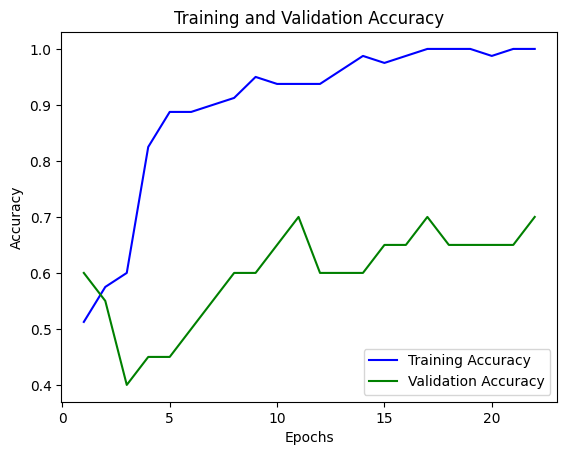


# Evaluate on test data
100/100 [==============================] - 0s 5ms/step - loss: 0.7410 - accuracy: 0.5200
Test loss, Test accuracy: [0.7409904599189758, 0.5199999809265137]
4/4 [==============================] - 0s 32ms/step
AUC Accuracy Score: 0.492



Current kl: 64
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69585, saving model to /tmp/checkpoint.h5
5/5 - 5s - loss: 0.7665 - accuracy: 0.4625 - val_loss: 0.6958 - val_accuracy: 0.4500 - 5s/epoch - 983ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69585
5/5 - 0s - loss: 0.5903 - accuracy: 0.7625 - val_loss: 0.7006 - val_accuracy: 0.2500 - 334ms/epoch - 67ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69585
5/5 - 0s - loss: 0.5072 - accuracy: 0.8250 - val_loss: 0.7070 - val_accuracy: 0.3000 - 355ms/epoch - 71ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69585
5/5 - 0s - loss: 0.4428 - accuracy: 0.8875 - val_loss: 0.7174 - val_accuracy: 0.3000 - 349ms/epoch -

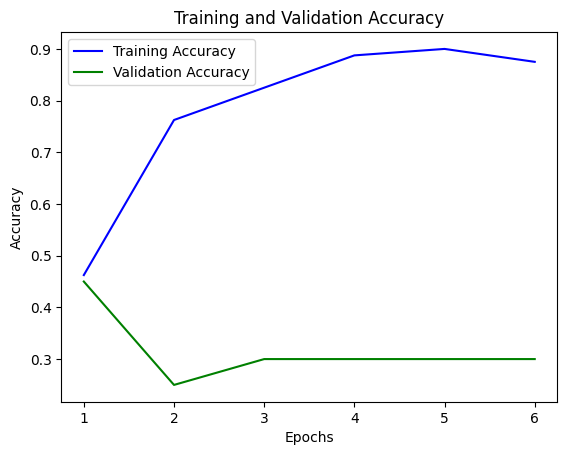


# Evaluate on test data
100/100 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5200
Test loss, Test accuracy: [0.6921653151512146, 0.5199999809265137]
4/4 [==============================] - 1s 32ms/step
AUC Accuracy Score: 0.5511999999999999



Current kl: 64
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69073, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7120 - accuracy: 0.5125 - val_loss: 0.6907 - val_accuracy: 0.5500 - 3s/epoch - 567ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69073
5/5 - 0s - loss: 0.6175 - accuracy: 0.7625 - val_loss: 0.6921 - val_accuracy: 0.4000 - 313ms/epoch - 63ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69073
5/5 - 0s - loss: 0.5565 - accuracy: 0.9375 - val_loss: 0.6923 - val_accuracy: 0.4500 - 305ms/epoch - 61ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69073
5/5 - 0s - loss: 0.4869 - accuracy: 0.9750 - val_loss: 0.6921 - val_accuracy: 0.3500 -

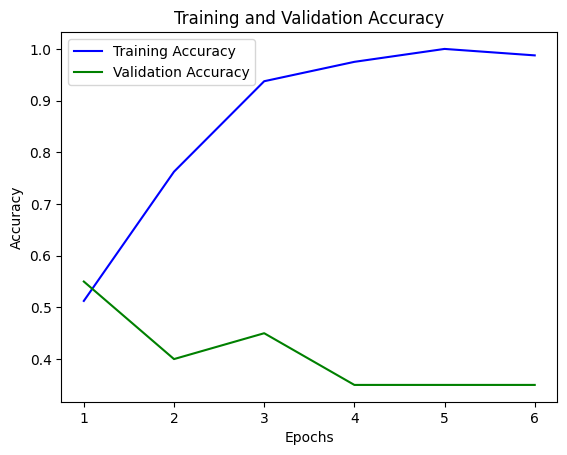


# Evaluate on test data
100/100 [==============================] - 1s 7ms/step - loss: 0.7016 - accuracy: 0.4500
Test loss, Test accuracy: [0.7016062140464783, 0.44999998807907104]
4/4 [==============================] - 0s 46ms/step
AUC Accuracy Score: 0.4488



Current kl: 64
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69170, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7535 - accuracy: 0.5250 - val_loss: 0.6917 - val_accuracy: 0.4500 - 3s/epoch - 570ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69170 to 0.69131, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6233 - accuracy: 0.7875 - val_loss: 0.6913 - val_accuracy: 0.6000 - 386ms/epoch - 77ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69131 to 0.69104, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6213 - accuracy: 0.6625 - val_loss: 0.6910 - val_accuracy: 0.6000 - 378ms/epoch - 76ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69104 to 0.69068, saving model 

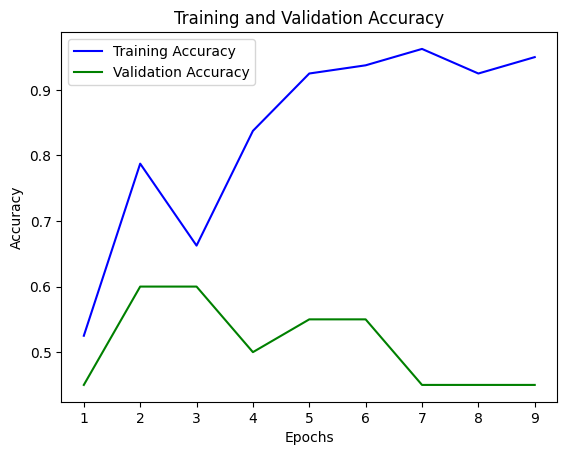


# Evaluate on test data
100/100 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.5700
Test loss, Test accuracy: [0.6845753192901611, 0.5699999928474426]
4/4 [==============================] - 0s 35ms/step
AUC Accuracy Score: 0.5871999999999999



Current kl: 128
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69158, saving model to /tmp/checkpoint.h5
5/5 - 5s - loss: 0.7086 - accuracy: 0.5125 - val_loss: 0.6916 - val_accuracy: 0.4000 - 5s/epoch - 945ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69158
5/5 - 0s - loss: 0.5819 - accuracy: 0.7750 - val_loss: 0.6921 - val_accuracy: 0.5000 - 389ms/epoch - 78ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69158
5/5 - 0s - loss: 0.4897 - accuracy: 0.8875 - val_loss: 0.6940 - val_accuracy: 0.4500 - 380ms/epoch - 76ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69158
5/5 - 0s - loss: 0.4087 - accuracy: 0.9250 - val_loss: 0.6986 - val_accuracy: 0.4000 -

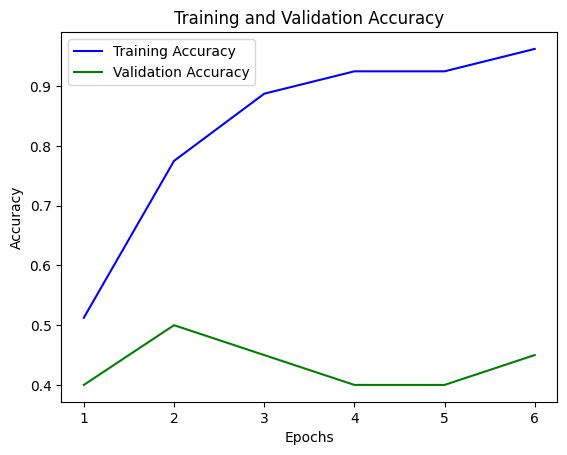


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6886 - accuracy: 0.5600
Test loss, Test accuracy: [0.6885945200920105, 0.5600000023841858]
4/4 [==============================] - 1s 36ms/step
AUC Accuracy Score: 0.5671999999999999



Current kl: 128
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69334, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7137 - accuracy: 0.4375 - val_loss: 0.6933 - val_accuracy: 0.3000 - 3s/epoch - 586ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69334 to 0.69230, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6178 - accuracy: 0.7750 - val_loss: 0.6923 - val_accuracy: 0.4000 - 424ms/epoch - 85ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69230 to 0.69056, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5464 - accuracy: 0.8750 - val_loss: 0.6906 - val_accuracy: 0.5500 - 401ms/epoch - 80ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69056 to 0.68834, 

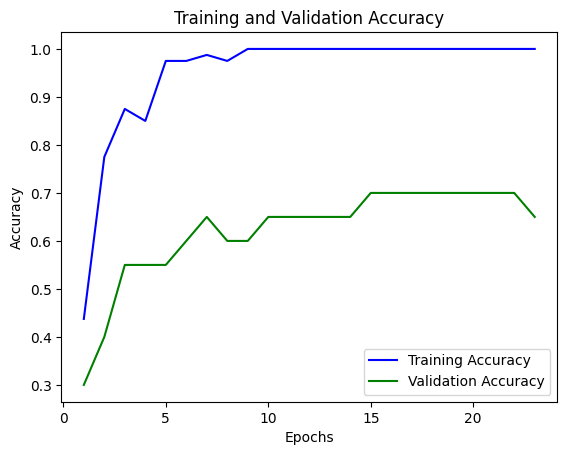


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.7283 - accuracy: 0.5600
Test loss, Test accuracy: [0.7282534241676331, 0.5600000023841858]
4/4 [==============================] - 0s 44ms/step
AUC Accuracy Score: 0.546



Current kl: 128
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69055, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7300 - accuracy: 0.4500 - val_loss: 0.6906 - val_accuracy: 0.5000 - 3s/epoch - 586ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69055 to 0.68985, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6375 - accuracy: 0.7000 - val_loss: 0.6898 - val_accuracy: 0.5500 - 403ms/epoch - 81ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.68985
5/5 - 0s - loss: 0.5756 - accuracy: 0.8375 - val_loss: 0.6910 - val_accuracy: 0.5000 - 366ms/epoch - 73ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.68985
5/5 - 0s - loss: 0.5113 - accuracy: 0.8500 - val_loss: 0.69

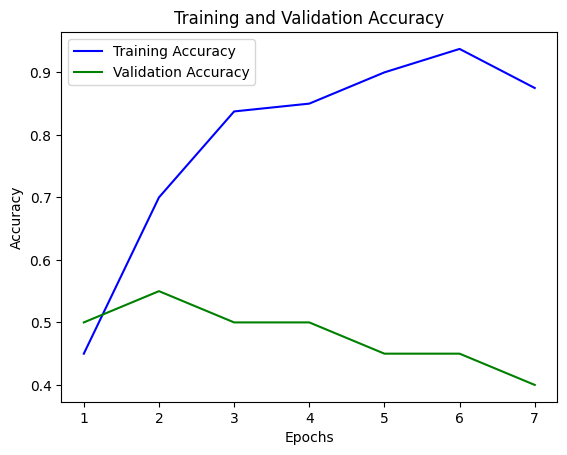


# Evaluate on test data
100/100 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.6000
Test loss, Test accuracy: [0.6884533166885376, 0.6000000238418579]
4/4 [==============================] - 0s 38ms/step
AUC Accuracy Score: 0.5788


('hand_imagery', 'feet_imagery')
Highest AUC Score: 0.6396000000000001
Best kl value: 32
Best d value: 0.25


<ipython-input-6-9535703458ea>:149: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Event Pair': event_pair, 'AUC Score': highest_auc_score, 'kl': best_kl, 'd': best_d}, ignore_index=True)


Not setting metadata
100 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
Not setting metadata
100 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



y_train shape: (100, 2)
y_test shape: (100, 2)
X_train shape: (100, 1, 204, 2001)
X_test shape: (100, 1, 204, 2001)


Current kl: 8
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69445, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7579 - accuracy: 0.4375 - val_loss: 0.6944 - val_accuracy: 0.3500 - 4s/epoch - 779ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69445
5/5 - 0s - loss: 0.6387 - accuracy: 0.6875 - val_loss: 0.6952 - val_accuracy: 0.3500 - 309ms/epoch - 62ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69445
5/5 - 0s - loss: 0.5836 - accuracy: 0.8750 - val_loss: 0.6962 - val_accuracy: 0.4000 - 283ms/epoch - 57ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69445
5/5 - 0s - loss: 0.5390 - accuracy: 0.9000 - val_loss: 0.6986 - val_accuracy: 0.4000 - 301ms/epoch - 60ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.69445
5/5 - 0s - loss: 0.4837 - accuracy: 0.8875 - val_loss: 0.7007 - val_accur

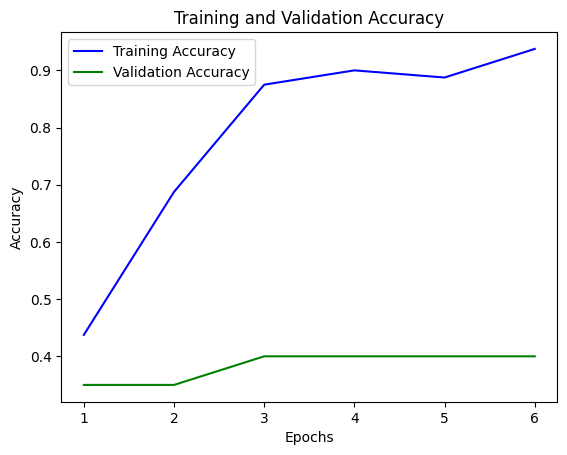


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6915 - accuracy: 0.4800
Test loss, Test accuracy: [0.691520631313324, 0.47999998927116394]
4/4 [==============================] - 0s 34ms/step
AUC Accuracy Score: 0.5236



Current kl: 8
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69030, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7140 - accuracy: 0.4375 - val_loss: 0.6903 - val_accuracy: 0.6500 - 3s/epoch - 672ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69030 to 0.68965, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6303 - accuracy: 0.7500 - val_loss: 0.6897 - val_accuracy: 0.6000 - 381ms/epoch - 76ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.68965 to 0.68889, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5667 - accuracy: 0.8625 - val_loss: 0.6889 - val_accuracy: 0.6500 - 347ms/epoch - 69ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68889 to 0.68711, saving model t

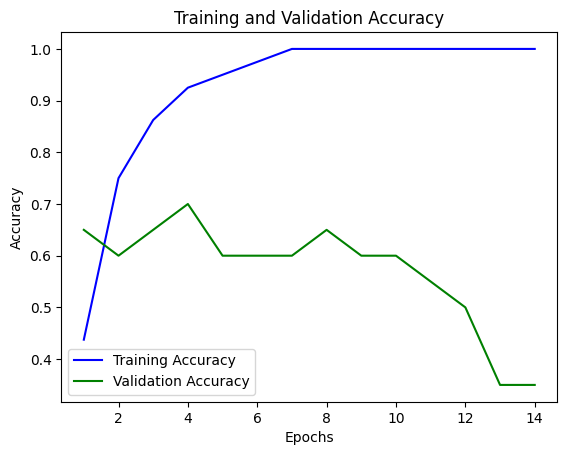


# Evaluate on test data
100/100 [==============================] - 0s 5ms/step - loss: 0.6770 - accuracy: 0.6100
Test loss, Test accuracy: [0.6769993305206299, 0.6100000143051147]
4/4 [==============================] - 0s 32ms/step
AUC Accuracy Score: 0.6272



Current kl: 8
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69481, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6892 - accuracy: 0.6250 - val_loss: 0.6948 - val_accuracy: 0.4500 - 3s/epoch - 585ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69481
5/5 - 0s - loss: 0.6193 - accuracy: 0.7250 - val_loss: 0.6949 - val_accuracy: 0.5000 - 317ms/epoch - 63ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69481 to 0.69342, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5632 - accuracy: 0.9125 - val_loss: 0.6934 - val_accuracy: 0.5500 - 346ms/epoch - 69ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69342 to 0.69199, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5

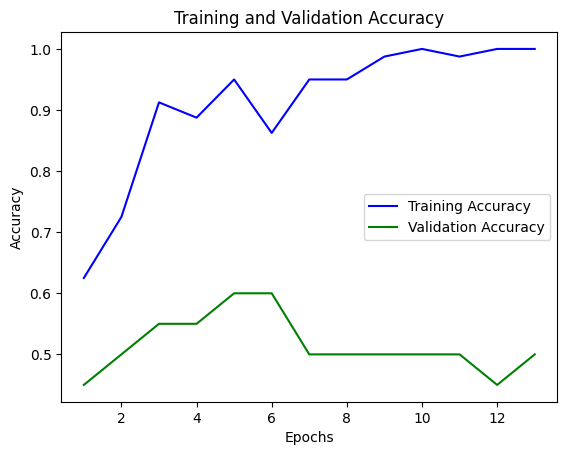


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6927 - accuracy: 0.5100
Test loss, Test accuracy: [0.6927245855331421, 0.5099999904632568]
4/4 [==============================] - 0s 32ms/step
AUC Accuracy Score: 0.5296000000000001



Current kl: 16
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69507, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7385 - accuracy: 0.5875 - val_loss: 0.6951 - val_accuracy: 0.4000 - 3s/epoch - 562ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69507 to 0.69438, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5848 - accuracy: 0.8375 - val_loss: 0.6944 - val_accuracy: 0.5500 - 333ms/epoch - 67ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69438
5/5 - 0s - loss: 0.5191 - accuracy: 0.9000 - val_loss: 0.6951 - val_accuracy: 0.5000 - 286ms/epoch - 57ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69438 to 0.69435, saving model to /tmp/checkpoint.h5
5/5 - 0

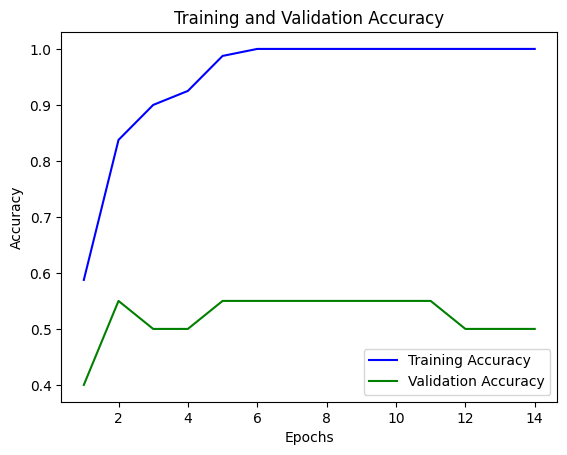


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6793 - accuracy: 0.5600
Test loss, Test accuracy: [0.6792871952056885, 0.5600000023841858]
4/4 [==============================] - 0s 40ms/step
AUC Accuracy Score: 0.6103999999999999



Current kl: 16
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69865, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7877 - accuracy: 0.4375 - val_loss: 0.6987 - val_accuracy: 0.3000 - 3s/epoch - 576ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69865
5/5 - 0s - loss: 0.6326 - accuracy: 0.6625 - val_loss: 0.6998 - val_accuracy: 0.4000 - 300ms/epoch - 60ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69865
5/5 - 0s - loss: 0.5782 - accuracy: 0.8500 - val_loss: 0.7007 - val_accuracy: 0.5500 - 270ms/epoch - 54ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69865
5/5 - 0s - loss: 0.5132 - accuracy: 0.9500 - val_loss: 0.7006 - val_accuracy: 0.5000 -

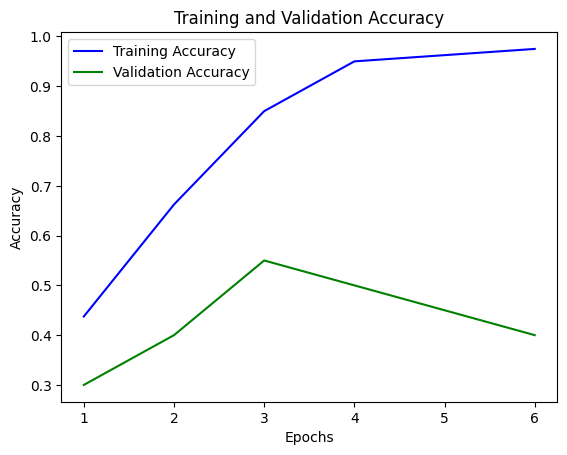


# Evaluate on test data
100/100 [==============================] - 1s 7ms/step - loss: 0.6877 - accuracy: 0.5600
Test loss, Test accuracy: [0.6877264380455017, 0.5600000023841858]
4/4 [==============================] - 0s 56ms/step
AUC Accuracy Score: 0.5984



Current kl: 16
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69590, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7598 - accuracy: 0.4375 - val_loss: 0.6959 - val_accuracy: 0.4000 - 3s/epoch - 573ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69590
5/5 - 0s - loss: 0.6526 - accuracy: 0.6250 - val_loss: 0.6969 - val_accuracy: 0.3500 - 283ms/epoch - 57ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69590
5/5 - 0s - loss: 0.5954 - accuracy: 0.7750 - val_loss: 0.6973 - val_accuracy: 0.4000 - 299ms/epoch - 60ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69590
5/5 - 0s - loss: 0.5643 - accuracy: 0.8500 - val_loss: 0.6976 - val_accuracy: 0.4500 - 271ms/epoch 

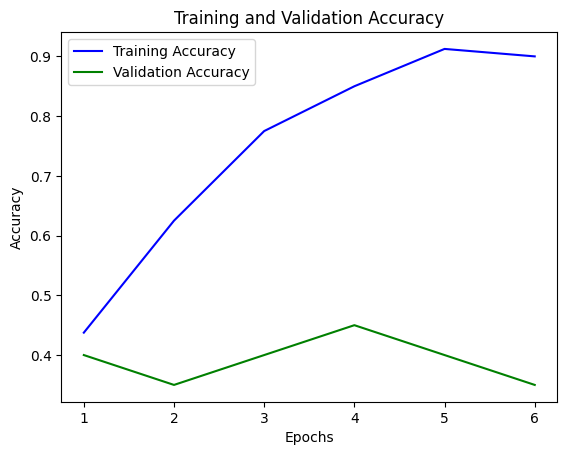


# Evaluate on test data
100/100 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.5500
Test loss, Test accuracy: [0.6877007484436035, 0.550000011920929]
4/4 [==============================] - 0s 28ms/step
AUC Accuracy Score: 0.5864



Current kl: 32
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69015, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6888 - accuracy: 0.5000 - val_loss: 0.6902 - val_accuracy: 0.6500 - 3s/epoch - 569ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69015 to 0.68854, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6023 - accuracy: 0.7875 - val_loss: 0.6885 - val_accuracy: 0.6500 - 393ms/epoch - 79ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.68854 to 0.68758, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5416 - accuracy: 0.8875 - val_loss: 0.6876 - val_accuracy: 0.7000 - 397ms/epoch - 79ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68758 to 0.68742, saving model to

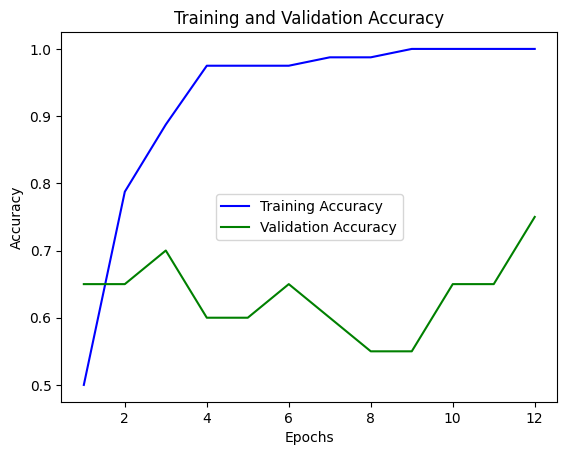


# Evaluate on test data
100/100 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5700
Test loss, Test accuracy: [0.6913712024688721, 0.5699999928474426]
4/4 [==============================] - 0s 35ms/step
AUC Accuracy Score: 0.5508



Current kl: 32
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69452, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7116 - accuracy: 0.5375 - val_loss: 0.6945 - val_accuracy: 0.4500 - 3s/epoch - 692ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69452 to 0.69379, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5952 - accuracy: 0.8250 - val_loss: 0.6938 - val_accuracy: 0.5000 - 340ms/epoch - 68ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69379 to 0.68992, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5366 - accuracy: 0.8875 - val_loss: 0.6899 - val_accuracy: 0.5000 - 339ms/epoch - 68ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68992 to 0.68675, saving model 

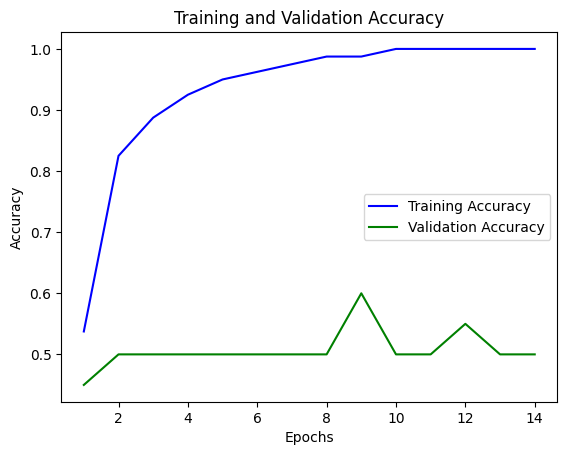


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6997 - accuracy: 0.5300
Test loss, Test accuracy: [0.6996599435806274, 0.5299999713897705]
4/4 [==============================] - 0s 41ms/step
AUC Accuracy Score: 0.5267999999999999



Current kl: 32
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69368, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7846 - accuracy: 0.4875 - val_loss: 0.6937 - val_accuracy: 0.5000 - 3s/epoch - 683ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69368
5/5 - 0s - loss: 0.6757 - accuracy: 0.5375 - val_loss: 0.6938 - val_accuracy: 0.5500 - 341ms/epoch - 68ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69368 to 0.69277, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6312 - accuracy: 0.6500 - val_loss: 0.6928 - val_accuracy: 0.5500 - 361ms/epoch - 72ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69277 to 0.69082, saving model to /tmp/checkpoint.h5
5/5 - 0

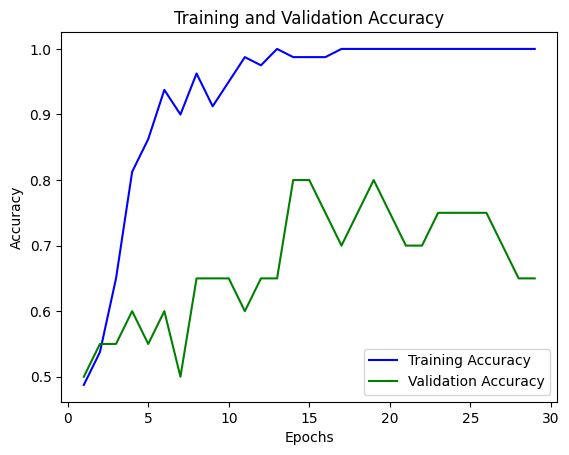


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6824 - accuracy: 0.5700
Test loss, Test accuracy: [0.6824386715888977, 0.5699999928474426]
4/4 [==============================] - 0s 43ms/step
AUC Accuracy Score: 0.6228



Current kl: 64
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69313, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7241 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4500 - 3s/epoch - 601ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69313
5/5 - 0s - loss: 0.6121 - accuracy: 0.7625 - val_loss: 0.6948 - val_accuracy: 0.5500 - 335ms/epoch - 67ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69313
5/5 - 0s - loss: 0.5321 - accuracy: 0.9000 - val_loss: 0.6968 - val_accuracy: 0.4500 - 340ms/epoch - 68ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69313
5/5 - 0s - loss: 0.4634 - accuracy: 0.9625 - val_loss: 0.6989 - val_accuracy: 0.4500 - 338ms/epoch 

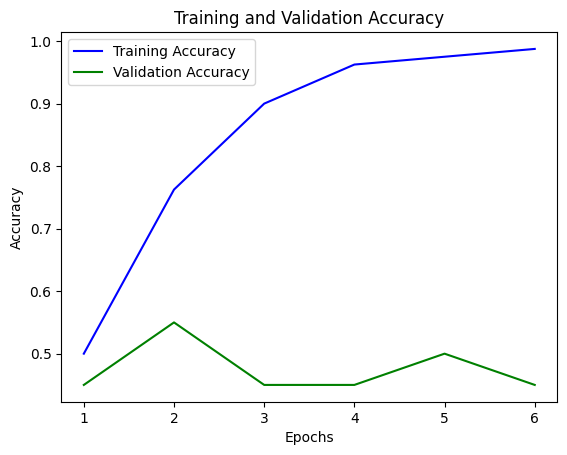


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6852 - accuracy: 0.6000
Test loss, Test accuracy: [0.6851969957351685, 0.6000000238418579]
4/4 [==============================] - 0s 40ms/step
AUC Accuracy Score: 0.61



Current kl: 64
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69401, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7348 - accuracy: 0.5000 - val_loss: 0.6940 - val_accuracy: 0.4000 - 3s/epoch - 688ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69401 to 0.69299, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6381 - accuracy: 0.6875 - val_loss: 0.6930 - val_accuracy: 0.4000 - 434ms/epoch - 87ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69299 to 0.69200, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5807 - accuracy: 0.9000 - val_loss: 0.6920 - val_accuracy: 0.5500 - 425ms/epoch - 85ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69200 to 0.69092, saving model to

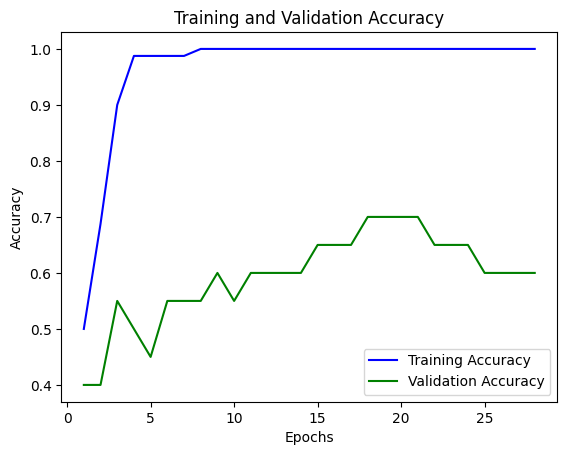


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6812 - accuracy: 0.5800
Test loss, Test accuracy: [0.6811935305595398, 0.5799999833106995]
4/4 [==============================] - 0s 32ms/step
AUC Accuracy Score: 0.5900000000000001



Current kl: 64
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69073, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7040 - accuracy: 0.5625 - val_loss: 0.6907 - val_accuracy: 0.5500 - 4s/epoch - 825ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69073
5/5 - 0s - loss: 0.6318 - accuracy: 0.7500 - val_loss: 0.6913 - val_accuracy: 0.5500 - 350ms/epoch - 70ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69073
5/5 - 0s - loss: 0.5667 - accuracy: 0.8500 - val_loss: 0.6918 - val_accuracy: 0.6000 - 340ms/epoch - 68ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69073
5/5 - 0s - loss: 0.5553 - accuracy: 0.8625 - val_loss: 0.6933 - val_accuracy: 0.6000 - 

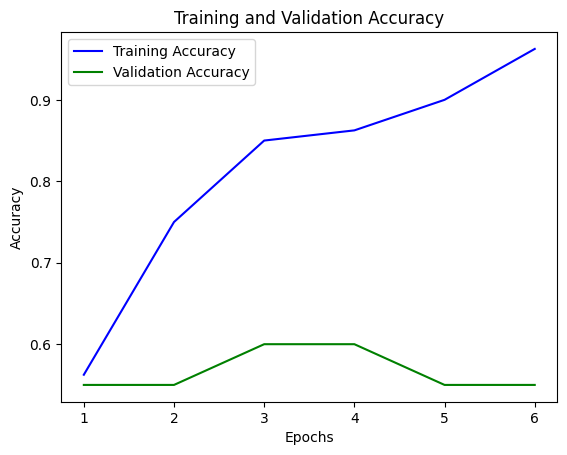


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6855 - accuracy: 0.5700
Test loss, Test accuracy: [0.6854995489120483, 0.5699999928474426]
4/4 [==============================] - 0s 34ms/step
AUC Accuracy Score: 0.608



Current kl: 128
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69294, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7124 - accuracy: 0.4875 - val_loss: 0.6929 - val_accuracy: 0.4500 - 3s/epoch - 576ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69294
5/5 - 0s - loss: 0.5814 - accuracy: 0.8375 - val_loss: 0.6935 - val_accuracy: 0.6000 - 391ms/epoch - 78ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69294
5/5 - 0s - loss: 0.4936 - accuracy: 0.9375 - val_loss: 0.6947 - val_accuracy: 0.5500 - 356ms/epoch - 71ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69294
5/5 - 0s - loss: 0.4153 - accuracy: 0.9750 - val_loss: 0.6961 - val_accuracy: 0.6500 - 356ms/epoch 

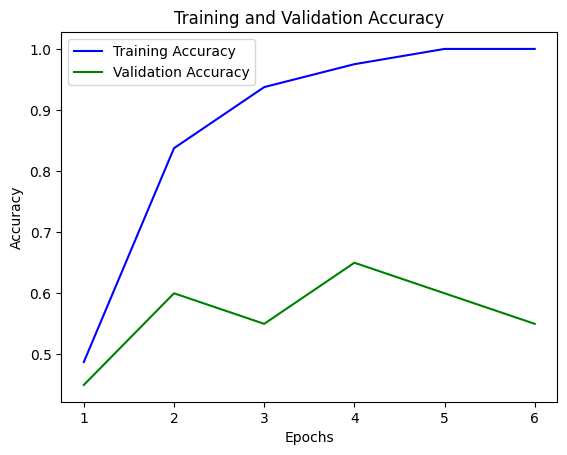


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6808 - accuracy: 0.6200
Test loss, Test accuracy: [0.6807815432548523, 0.6200000047683716]
4/4 [==============================] - 0s 45ms/step
AUC Accuracy Score: 0.6172



Current kl: 128
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69276, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7541 - accuracy: 0.4250 - val_loss: 0.6928 - val_accuracy: 0.5000 - 4s/epoch - 803ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69276
5/5 - 0s - loss: 0.6007 - accuracy: 0.7375 - val_loss: 0.6934 - val_accuracy: 0.4500 - 365ms/epoch - 73ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69276
5/5 - 0s - loss: 0.5147 - accuracy: 0.9125 - val_loss: 0.6930 - val_accuracy: 0.5000 - 351ms/epoch - 70ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69276 to 0.69234, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.4377 - accuracy: 0.9500 - val_loss: 0.

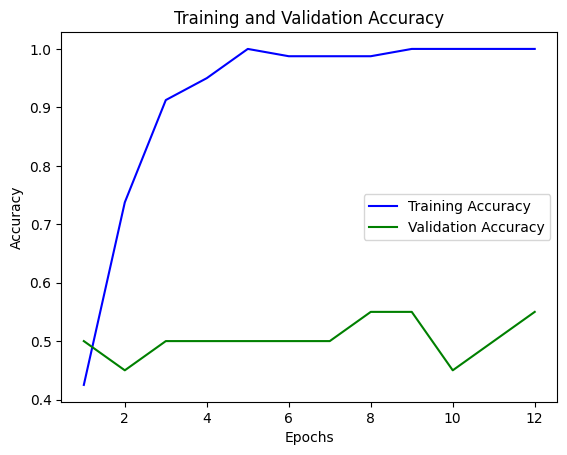


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6861 - accuracy: 0.5500
Test loss, Test accuracy: [0.6860897541046143, 0.550000011920929]
4/4 [==============================] - 0s 49ms/step
AUC Accuracy Score: 0.5768



Current kl: 128
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69174, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7564 - accuracy: 0.4500 - val_loss: 0.6917 - val_accuracy: 0.5000 - 4s/epoch - 859ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69174
5/5 - 0s - loss: 0.6112 - accuracy: 0.7625 - val_loss: 0.6938 - val_accuracy: 0.4500 - 367ms/epoch - 73ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69174
5/5 - 0s - loss: 0.5878 - accuracy: 0.8125 - val_loss: 0.6963 - val_accuracy: 0.4000 - 361ms/epoch - 72ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69174
5/5 - 0s - loss: 0.5333 - accuracy: 0.8250 - val_loss: 0.6984 - val_accuracy: 0.5000 - 377ms/epoch 

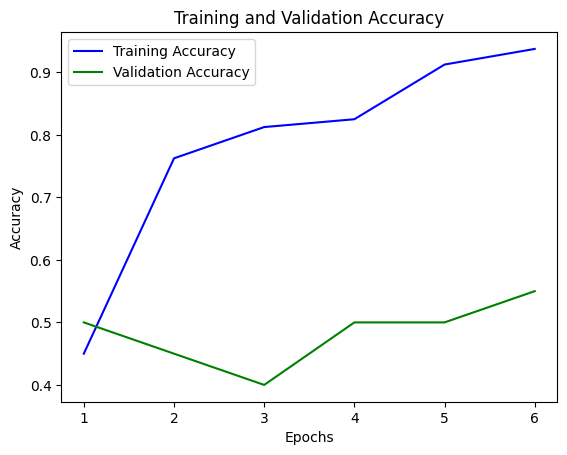


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6874 - accuracy: 0.5200
Test loss, Test accuracy: [0.6874203681945801, 0.5199999809265137]
4/4 [==============================] - 0s 46ms/step
AUC Accuracy Score: 0.5672


('hand_imagery', 'subtraction_imagery')
Highest AUC Score: 0.6272
Best kl value: 8
Best d value: 0.25


<ipython-input-6-9535703458ea>:149: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Event Pair': event_pair, 'AUC Score': highest_auc_score, 'kl': best_kl, 'd': best_d}, ignore_index=True)


Not setting metadata
100 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
Not setting metadata
100 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



y_train shape: (100, 2)
y_test shape: (100, 2)
X_train shape: (100, 1, 204, 2001)
X_test shape: (100, 1, 204, 2001)


Current kl: 8
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69527, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7971 - accuracy: 0.3500 - val_loss: 0.6953 - val_accuracy: 0.4000 - 4s/epoch - 737ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69527 to 0.69360, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6071 - accuracy: 0.7625 - val_loss: 0.6936 - val_accuracy: 0.4500 - 455ms/epoch - 91ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69360 to 0.69239, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5462 - accuracy: 0.8750 - val_loss: 0.6924 - val_accuracy: 0.4500 - 403ms/epoch - 81ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69239 to 0.69120, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.4886 - accuracy: 0.8875 - val_loss: 0.6912 - val_accuracy: 0.5000 - 386ms/epoch - 77ms/step
Epoch 5/200



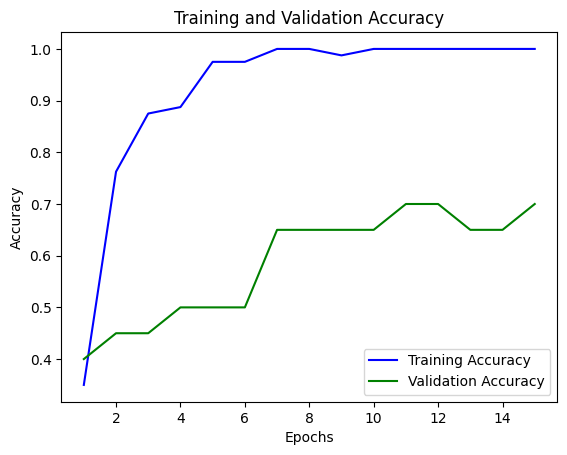


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.7025 - accuracy: 0.4300
Test loss, Test accuracy: [0.7024643421173096, 0.4300000071525574]
4/4 [==============================] - 0s 33ms/step
AUC Accuracy Score: 0.47239999999999993



Current kl: 8
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69571, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6737 - accuracy: 0.5625 - val_loss: 0.6957 - val_accuracy: 0.3000 - 3s/epoch - 624ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69571 to 0.69536, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6110 - accuracy: 0.7375 - val_loss: 0.6954 - val_accuracy: 0.3500 - 383ms/epoch - 77ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69536
5/5 - 0s - loss: 0.5339 - accuracy: 0.9250 - val_loss: 0.6959 - val_accuracy: 0.2500 - 342ms/epoch - 68ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69536
5/5 - 0s - loss: 0.4911 - accuracy: 0.9500 - v

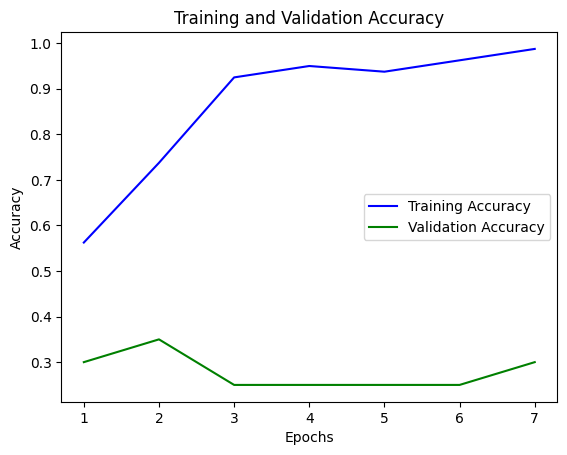


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6939 - accuracy: 0.4600
Test loss, Test accuracy: [0.6939101219177246, 0.46000000834465027]
4/4 [==============================] - 0s 36ms/step
AUC Accuracy Score: 0.49639999999999995



Current kl: 8
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69379, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6983 - accuracy: 0.4625 - val_loss: 0.6938 - val_accuracy: 0.5500 - 3s/epoch - 580ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69379
5/5 - 0s - loss: 0.6425 - accuracy: 0.7500 - val_loss: 0.6953 - val_accuracy: 0.4500 - 319ms/epoch - 64ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69379
5/5 - 0s - loss: 0.5951 - accuracy: 0.7125 - val_loss: 0.6969 - val_accuracy: 0.4500 - 270ms/epoch - 54ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69379
5/5 - 0s - loss: 0.5566 - accuracy: 0.7625 - val_loss: 0.6978 - val_accuracy: 0.4500 -

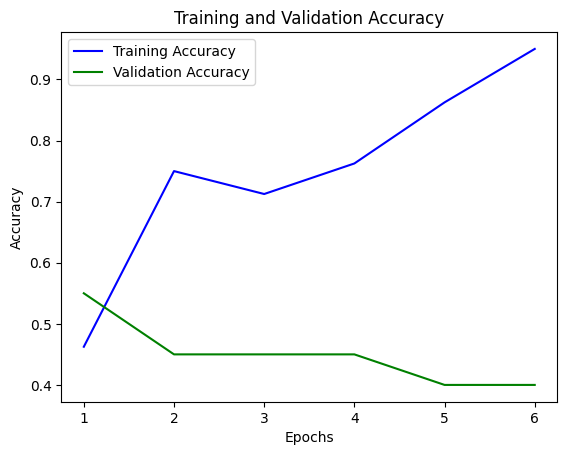


# Evaluate on test data
100/100 [==============================] - 0s 5ms/step - loss: 0.6958 - accuracy: 0.5000
Test loss, Test accuracy: [0.6958444714546204, 0.5]
4/4 [==============================] - 0s 28ms/step
AUC Accuracy Score: 0.44920000000000004



Current kl: 16
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69231, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6827 - accuracy: 0.6125 - val_loss: 0.6923 - val_accuracy: 0.5000 - 3s/epoch - 612ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69231
5/5 - 0s - loss: 0.6071 - accuracy: 0.7875 - val_loss: 0.6928 - val_accuracy: 0.5000 - 365ms/epoch - 73ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69231
5/5 - 0s - loss: 0.5389 - accuracy: 0.8750 - val_loss: 0.6929 - val_accuracy: 0.4500 - 349ms/epoch - 70ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69231
5/5 - 0s - loss: 0.4720 - accuracy: 0.9500 - val_loss: 0.6928 - val_accuracy: 0.4500 - 342ms/epoch - 

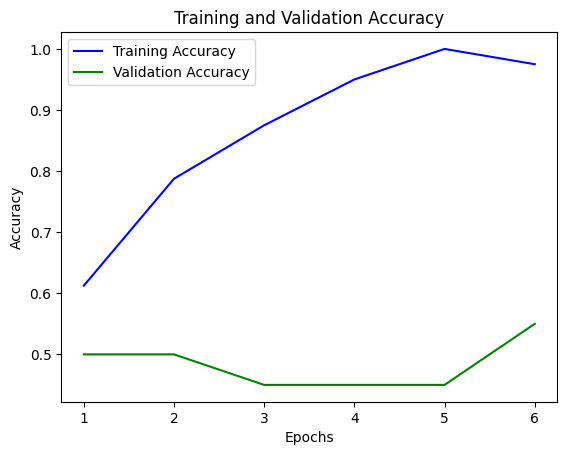


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6960 - accuracy: 0.4800
Test loss, Test accuracy: [0.6959547996520996, 0.47999998927116394]
4/4 [==============================] - 0s 38ms/step
AUC Accuracy Score: 0.4824



Current kl: 16
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69385, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7405 - accuracy: 0.4625 - val_loss: 0.6938 - val_accuracy: 0.5500 - 3s/epoch - 568ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69385 to 0.69095, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6181 - accuracy: 0.6625 - val_loss: 0.6910 - val_accuracy: 0.6500 - 363ms/epoch - 73ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69095 to 0.68729, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5533 - accuracy: 0.8250 - val_loss: 0.6873 - val_accuracy: 0.6500 - 350ms/epoch - 70ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68729 to 0.68375, saving model

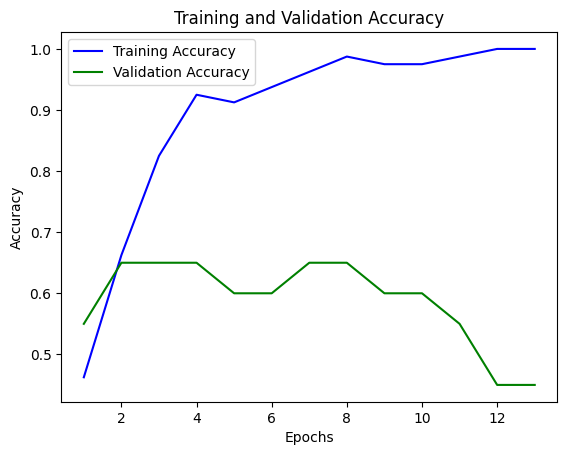


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6957 - accuracy: 0.5000
Test loss, Test accuracy: [0.6957356333732605, 0.5]
4/4 [==============================] - 0s 43ms/step
AUC Accuracy Score: 0.5424



Current kl: 16
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69428, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7040 - accuracy: 0.5250 - val_loss: 0.6943 - val_accuracy: 0.4500 - 3s/epoch - 569ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69428 to 0.69280, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6233 - accuracy: 0.6375 - val_loss: 0.6928 - val_accuracy: 0.4000 - 334ms/epoch - 67ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69280 to 0.69099, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5922 - accuracy: 0.6625 - val_loss: 0.6910 - val_accuracy: 0.5000 - 352ms/epoch - 70ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69099 to 0.69023, saving model to /tmp/checkpoi

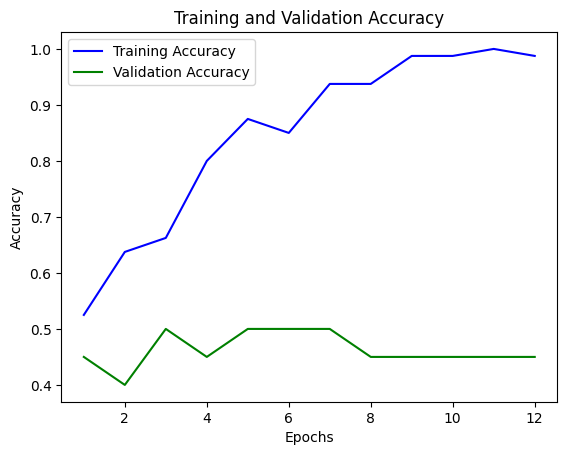


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.7042 - accuracy: 0.4900
Test loss, Test accuracy: [0.7041865587234497, 0.49000000953674316]
4/4 [==============================] - 0s 57ms/step
AUC Accuracy Score: 0.4772



Current kl: 32
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69183, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.6831 - accuracy: 0.5375 - val_loss: 0.6918 - val_accuracy: 0.6500 - 4s/epoch - 897ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69183 to 0.69068, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5943 - accuracy: 0.8375 - val_loss: 0.6907 - val_accuracy: 0.5500 - 381ms/epoch - 76ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69068 to 0.68973, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5152 - accuracy: 0.9250 - val_loss: 0.6897 - val_accuracy: 0.6000 - 334ms/epoch - 67ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68973 to 0.68876, saving model 

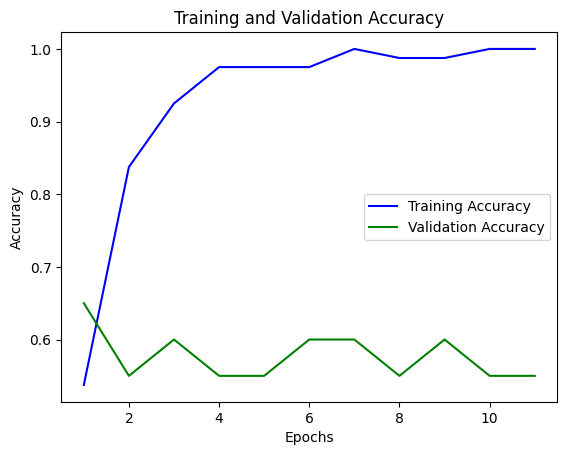


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.7077 - accuracy: 0.4600
Test loss, Test accuracy: [0.7076582908630371, 0.46000000834465027]
4/4 [==============================] - 0s 35ms/step
AUC Accuracy Score: 0.46559999999999996



Current kl: 32
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69075, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6963 - accuracy: 0.5000 - val_loss: 0.6908 - val_accuracy: 0.6500 - 3s/epoch - 609ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69075 to 0.69059, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6134 - accuracy: 0.7875 - val_loss: 0.6906 - val_accuracy: 0.5500 - 423ms/epoch - 85ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69059
5/5 - 0s - loss: 0.5480 - accuracy: 0.9000 - val_loss: 0.6912 - val_accuracy: 0.5500 - 326ms/epoch - 65ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69059
5/5 - 0s - loss: 0.4811 - accuracy: 0.9250 -

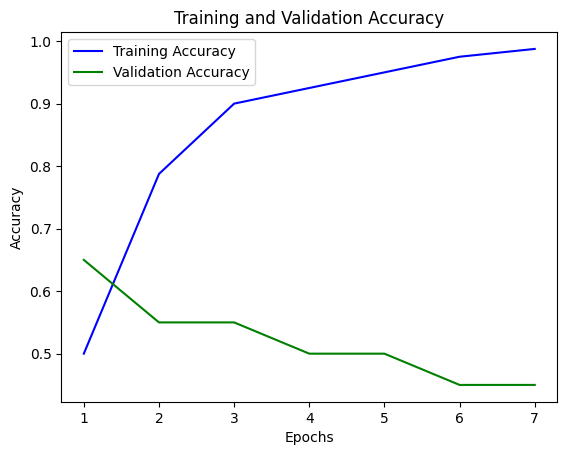


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6999 - accuracy: 0.4900
Test loss, Test accuracy: [0.6999449133872986, 0.49000000953674316]
4/4 [==============================] - 0s 36ms/step
AUC Accuracy Score: 0.48960000000000004



Current kl: 32
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69388, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7506 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.4500 - 3s/epoch - 577ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69388 to 0.69178, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6397 - accuracy: 0.6375 - val_loss: 0.6918 - val_accuracy: 0.5000 - 376ms/epoch - 75ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69178 to 0.68968, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6132 - accuracy: 0.6875 - val_loss: 0.6897 - val_accuracy: 0.5500 - 371ms/epoch - 74ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68968 to 0.68590, 

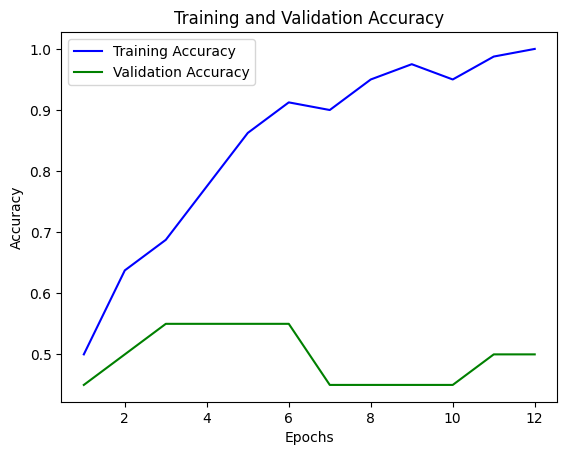


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.7061 - accuracy: 0.5200
Test loss, Test accuracy: [0.7061397433280945, 0.5199999809265137]
4/4 [==============================] - 0s 41ms/step
AUC Accuracy Score: 0.5016



Current kl: 64
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69763, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7141 - accuracy: 0.4500 - val_loss: 0.6976 - val_accuracy: 0.3500 - 3s/epoch - 577ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69763 to 0.69713, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5836 - accuracy: 0.7875 - val_loss: 0.6971 - val_accuracy: 0.3000 - 398ms/epoch - 80ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69713 to 0.69423, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5188 - accuracy: 0.8500 - val_loss: 0.6942 - val_accuracy: 0.3500 - 356ms/epoch - 71ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69423 to 0.68870, saving model t

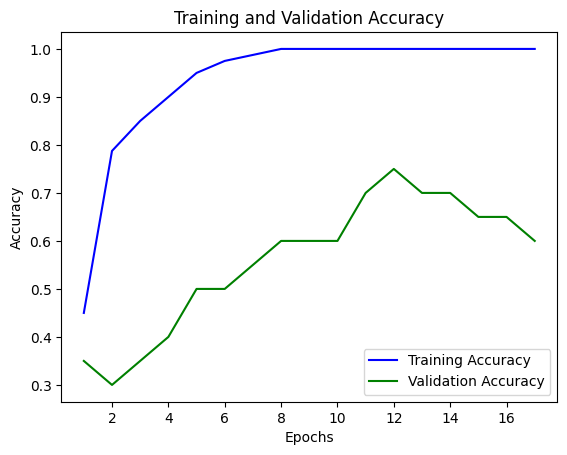


# Evaluate on test data
100/100 [==============================] - 1s 7ms/step - loss: 0.7134 - accuracy: 0.5300
Test loss, Test accuracy: [0.7134168744087219, 0.5299999713897705]
4/4 [==============================] - 0s 52ms/step
AUC Accuracy Score: 0.558



Current kl: 64
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69371, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7210 - accuracy: 0.3875 - val_loss: 0.6937 - val_accuracy: 0.4000 - 3s/epoch - 647ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69371
5/5 - 0s - loss: 0.6378 - accuracy: 0.7750 - val_loss: 0.6950 - val_accuracy: 0.3500 - 321ms/epoch - 64ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69371
5/5 - 0s - loss: 0.5841 - accuracy: 0.6875 - val_loss: 0.6947 - val_accuracy: 0.5000 - 319ms/epoch - 64ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69371 to 0.69182, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5348 - accuracy: 0.8625 - val_loss: 0.69

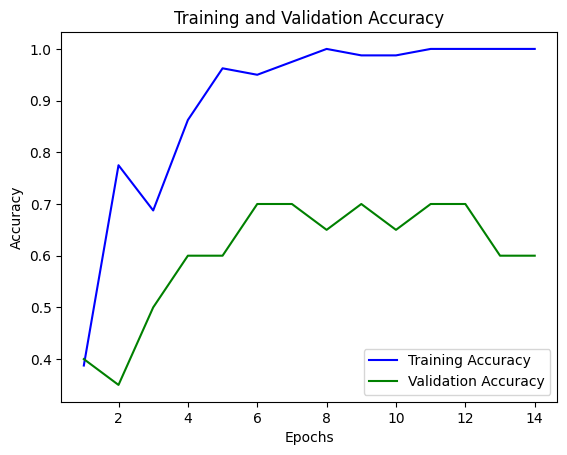


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6948 - accuracy: 0.5300
Test loss, Test accuracy: [0.6947885155677795, 0.5299999713897705]
4/4 [==============================] - 0s 42ms/step
AUC Accuracy Score: 0.542



Current kl: 64
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69423, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7084 - accuracy: 0.5750 - val_loss: 0.6942 - val_accuracy: 0.4500 - 3s/epoch - 575ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69423 to 0.69290, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6384 - accuracy: 0.7125 - val_loss: 0.6929 - val_accuracy: 0.4500 - 375ms/epoch - 75ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69290 to 0.69132, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6008 - accuracy: 0.7625 - val_loss: 0.6913 - val_accuracy: 0.6000 - 360ms/epoch - 72ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69132 to 0.68993, saving model to

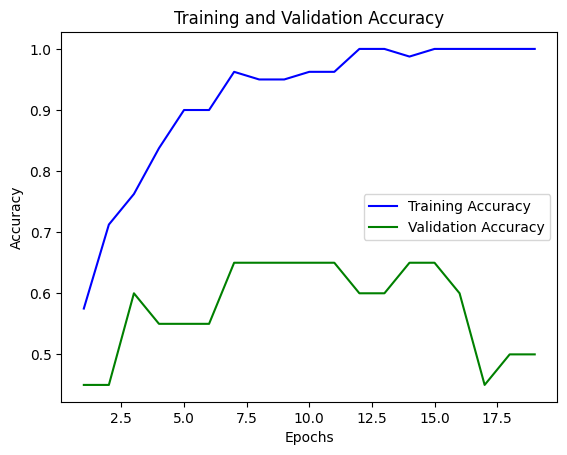


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6909 - accuracy: 0.5500
Test loss, Test accuracy: [0.6908788084983826, 0.550000011920929]
4/4 [==============================] - 0s 39ms/step
AUC Accuracy Score: 0.5756



Current kl: 128
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69342, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7122 - accuracy: 0.4750 - val_loss: 0.6934 - val_accuracy: 0.5500 - 3s/epoch - 595ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69342 to 0.69305, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6188 - accuracy: 0.8375 - val_loss: 0.6930 - val_accuracy: 0.5000 - 408ms/epoch - 82ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69305
5/5 - 0s - loss: 0.5448 - accuracy: 0.9000 - val_loss: 0.6936 - val_accuracy: 0.5000 - 388ms/epoch - 78ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69305
5/5 - 0s - loss: 0.4973 - accuracy: 0.8875 - val_loss: 0.69

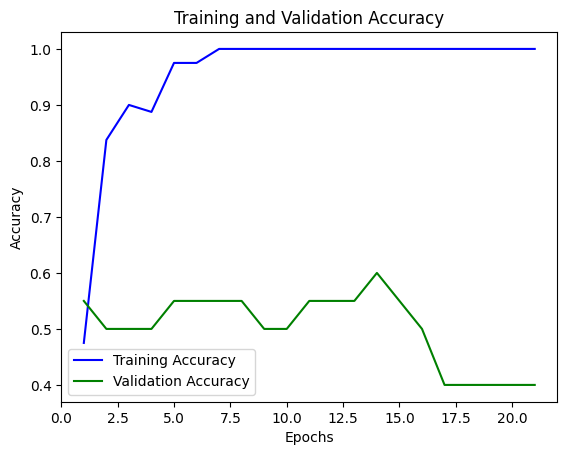


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.7152 - accuracy: 0.5100
Test loss, Test accuracy: [0.7152301073074341, 0.5099999904632568]
4/4 [==============================] - 0s 49ms/step
AUC Accuracy Score: 0.5272000000000001



Current kl: 128
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69186, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7323 - accuracy: 0.5375 - val_loss: 0.6919 - val_accuracy: 0.6500 - 4s/epoch - 714ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69186 to 0.69097, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5849 - accuracy: 0.8125 - val_loss: 0.6910 - val_accuracy: 0.5500 - 439ms/epoch - 88ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69097 to 0.68978, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5205 - accuracy: 0.9125 - val_loss: 0.6898 - val_accuracy: 0.5500 - 412ms/epoch - 82ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68978 to 0.68927, 

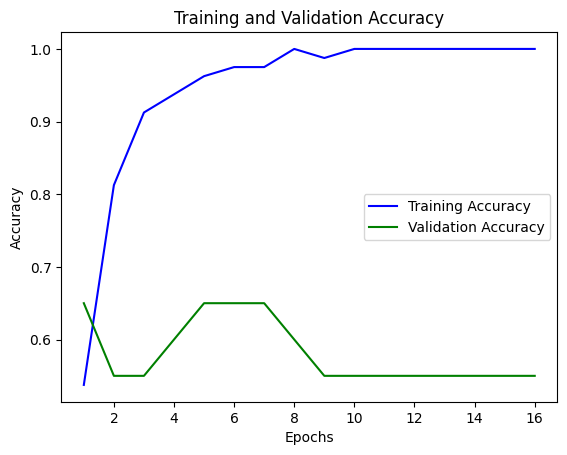


# Evaluate on test data
100/100 [==============================] - 1s 7ms/step - loss: 0.7511 - accuracy: 0.4600
Test loss, Test accuracy: [0.7510597109794617, 0.46000000834465027]
4/4 [==============================] - 0s 45ms/step
AUC Accuracy Score: 0.4372



Current kl: 128
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69537, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6824 - accuracy: 0.5250 - val_loss: 0.6954 - val_accuracy: 0.3500 - 3s/epoch - 601ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69537 to 0.69413, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6473 - accuracy: 0.6125 - val_loss: 0.6941 - val_accuracy: 0.3500 - 417ms/epoch - 83ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69413 to 0.68934, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5903 - accuracy: 0.7875 - val_loss: 0.6893 - val_accuracy: 0.6000 - 409ms/epoch - 82ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68934 to 0.68244, saving model

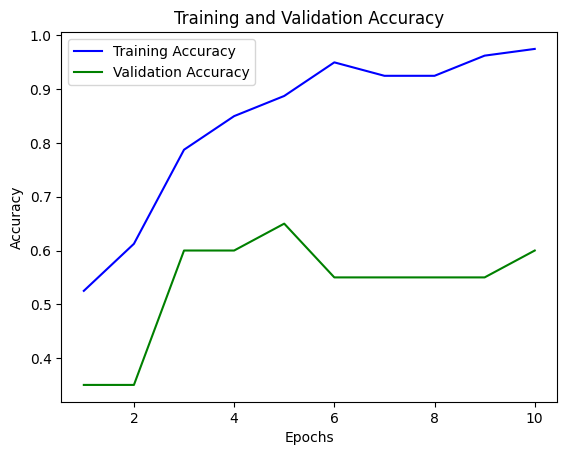


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.7291 - accuracy: 0.4800
Test loss, Test accuracy: [0.7291011810302734, 0.47999998927116394]
4/4 [==============================] - 0s 46ms/step
AUC Accuracy Score: 0.48360000000000003


('hand_imagery', 'word_imagery')
Highest AUC Score: 0.5756
Best kl value: 64
Best d value: 0.5


<ipython-input-6-9535703458ea>:149: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Event Pair': event_pair, 'AUC Score': highest_auc_score, 'kl': best_kl, 'd': best_d}, ignore_index=True)


Not setting metadata
100 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
Not setting metadata
100 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



y_train shape: (100, 2)
y_test shape: (100, 2)
X_train shape: (100, 1, 204, 2001)
X_test shape: (100, 1, 204, 2001)


Current kl: 8
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69845, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7391 - accuracy: 0.5125 - val_loss: 0.6985 - val_accuracy: 0.2500 - 3s/epoch - 582ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69845 to 0.69836, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6115 - accuracy: 0.8250 - val_loss: 0.6984 - val_accuracy: 0.3000 - 359ms/epoch - 72ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69836
5/5 - 0s - loss: 0.5360 - accuracy: 0.9625 - val_loss: 0.6984 - val_accuracy: 0.4000 - 277ms/epoch - 55ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69836
5/5 - 0s - loss: 0.4821 - accuracy: 0.9750 - val_loss: 0.6991 - val_accuracy: 0.4000 - 276ms/epoch - 55ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.69836
5/5 - 0s - loss: 0.4296 - accurac

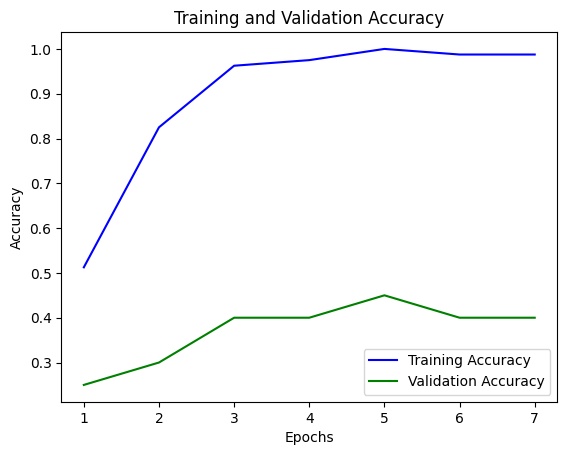


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6842 - accuracy: 0.5900
Test loss, Test accuracy: [0.6842444539070129, 0.5899999737739563]
4/4 [==============================] - 0s 39ms/step
AUC Accuracy Score: 0.6164000000000001



Current kl: 8
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69395, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7018 - accuracy: 0.4750 - val_loss: 0.6940 - val_accuracy: 0.6000 - 3s/epoch - 681ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69395
5/5 - 0s - loss: 0.6059 - accuracy: 0.8000 - val_loss: 0.6951 - val_accuracy: 0.6000 - 303ms/epoch - 61ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69395
5/5 - 0s - loss: 0.5452 - accuracy: 0.9250 - val_loss: 0.6972 - val_accuracy: 0.5500 - 310ms/epoch - 62ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69395
5/5 - 0s - loss: 0.4933 - accuracy: 0.9375 - val_loss: 0.6999 - val_accuracy: 0.5000 - 

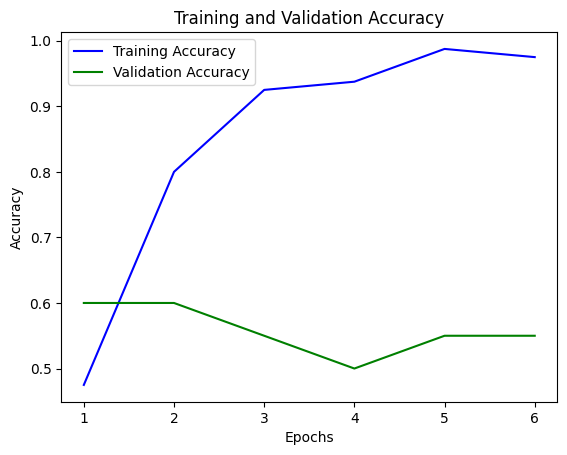


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6781 - accuracy: 0.6500
Test loss, Test accuracy: [0.6780681610107422, 0.6499999761581421]
4/4 [==============================] - 0s 37ms/step
AUC Accuracy Score: 0.7208000000000001



Current kl: 8
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69184, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6869 - accuracy: 0.5375 - val_loss: 0.6918 - val_accuracy: 0.4500 - 3s/epoch - 607ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69184
5/5 - 0s - loss: 0.6460 - accuracy: 0.6875 - val_loss: 0.6922 - val_accuracy: 0.4500 - 360ms/epoch - 72ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69184
5/5 - 0s - loss: 0.5983 - accuracy: 0.8250 - val_loss: 0.6926 - val_accuracy: 0.4500 - 302ms/epoch - 60ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69184
5/5 - 0s - loss: 0.5679 - accuracy: 0.9125 - val_loss: 0.6922 - val_accuracy: 0.4500 - 3

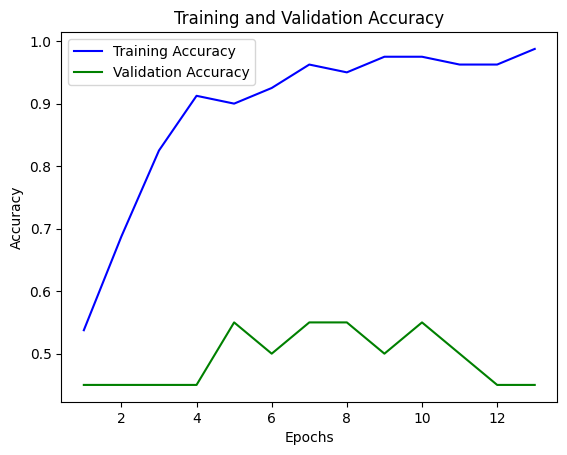


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6727 - accuracy: 0.6000
Test loss, Test accuracy: [0.6726901531219482, 0.6000000238418579]
4/4 [==============================] - 0s 32ms/step
AUC Accuracy Score: 0.6464



Current kl: 16
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69240, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7066 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.6000 - 3s/epoch - 590ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69240
5/5 - 0s - loss: 0.5987 - accuracy: 0.7750 - val_loss: 0.6960 - val_accuracy: 0.4500 - 304ms/epoch - 61ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69240
5/5 - 0s - loss: 0.5127 - accuracy: 0.9375 - val_loss: 0.7020 - val_accuracy: 0.4000 - 279ms/epoch - 56ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69240
5/5 - 0s - loss: 0.4404 - accuracy: 0.9875 - val_loss: 0.7089 - val_accuracy: 0.4000 - 308ms/epoch 

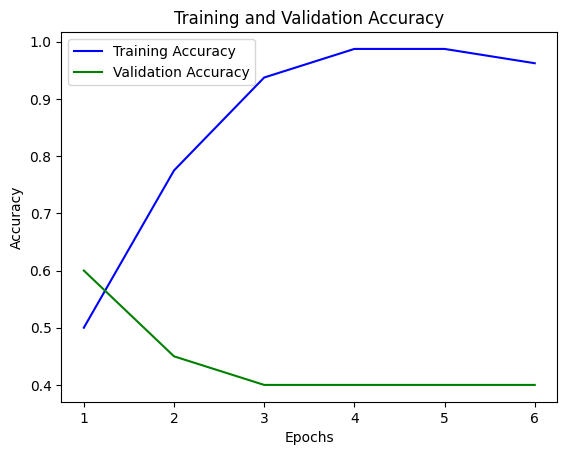


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6820 - accuracy: 0.5400
Test loss, Test accuracy: [0.6820213198661804, 0.5400000214576721]
4/4 [==============================] - 0s 31ms/step
AUC Accuracy Score: 0.6052



Current kl: 16
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69311, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7042 - accuracy: 0.5500 - val_loss: 0.6931 - val_accuracy: 0.5000 - 4s/epoch - 804ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69311
5/5 - 0s - loss: 0.6032 - accuracy: 0.8000 - val_loss: 0.6962 - val_accuracy: 0.4000 - 341ms/epoch - 68ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69311
5/5 - 0s - loss: 0.5295 - accuracy: 0.9125 - val_loss: 0.6993 - val_accuracy: 0.3000 - 337ms/epoch - 67ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69311
5/5 - 0s - loss: 0.4613 - accuracy: 0.9750 - val_loss: 0.7032 - val_accuracy: 0.3000 - 340ms/epoch

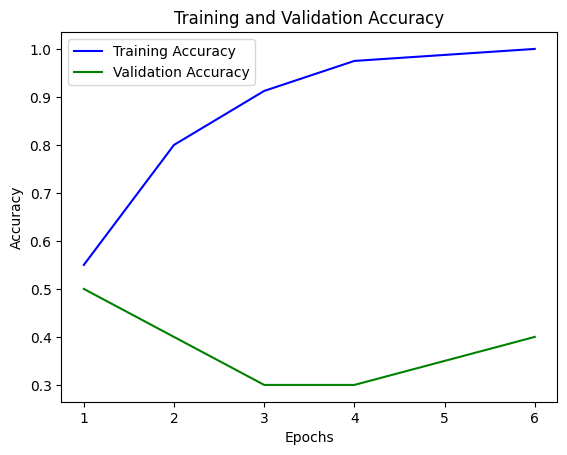


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6849 - accuracy: 0.5800
Test loss, Test accuracy: [0.6849445104598999, 0.5799999833106995]
4/4 [==============================] - 0s 43ms/step
AUC Accuracy Score: 0.6432



Current kl: 16
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69214, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7888 - accuracy: 0.5250 - val_loss: 0.6921 - val_accuracy: 0.5500 - 3s/epoch - 696ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69214 to 0.69184, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6379 - accuracy: 0.7250 - val_loss: 0.6918 - val_accuracy: 0.6000 - 389ms/epoch - 78ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69184
5/5 - 0s - loss: 0.5864 - accuracy: 0.8500 - val_loss: 0.6920 - val_accuracy: 0.6000 - 275ms/epoch - 55ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69184
5/5 - 0s - loss: 0.5456 - accuracy: 0.8875 - val_loss: 0.69

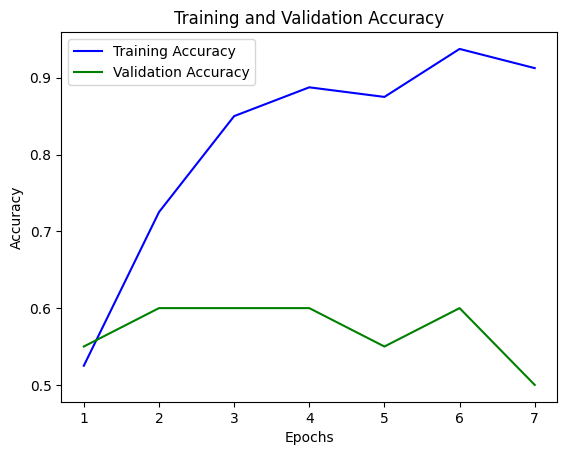


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6790 - accuracy: 0.6500
Test loss, Test accuracy: [0.6790275573730469, 0.6499999761581421]
4/4 [==============================] - 0s 43ms/step
AUC Accuracy Score: 0.6828000000000001



Current kl: 32
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69445, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7007 - accuracy: 0.5375 - val_loss: 0.6944 - val_accuracy: 0.4500 - 4s/epoch - 763ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69445
5/5 - 0s - loss: 0.5888 - accuracy: 0.7875 - val_loss: 0.6946 - val_accuracy: 0.4500 - 335ms/epoch - 67ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69445 to 0.69428, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5203 - accuracy: 0.8875 - val_loss: 0.6943 - val_accuracy: 0.4000 - 369ms/epoch - 74ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69428
5/5 - 0s - loss: 0.4466 - accuracy: 0.9625 - va

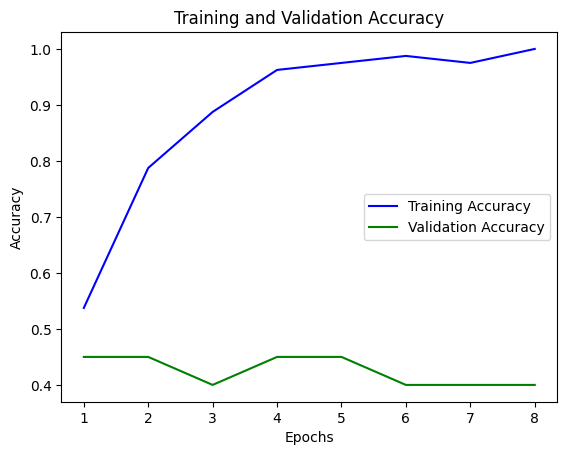


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6801 - accuracy: 0.5400
Test loss, Test accuracy: [0.6800717711448669, 0.5400000214576721]
4/4 [==============================] - 0s 40ms/step
AUC Accuracy Score: 0.6108



Current kl: 32
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69961, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6725 - accuracy: 0.5875 - val_loss: 0.6996 - val_accuracy: 0.3000 - 3s/epoch - 586ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69961
5/5 - 0s - loss: 0.5956 - accuracy: 0.8500 - val_loss: 0.7038 - val_accuracy: 0.3500 - 327ms/epoch - 65ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69961
5/5 - 0s - loss: 0.5158 - accuracy: 0.9125 - val_loss: 0.7078 - val_accuracy: 0.4500 - 350ms/epoch - 70ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69961
5/5 - 0s - loss: 0.4367 - accuracy: 0.9250 - val_loss: 0.7098 - val_accuracy: 0.5000 - 356ms/epoch

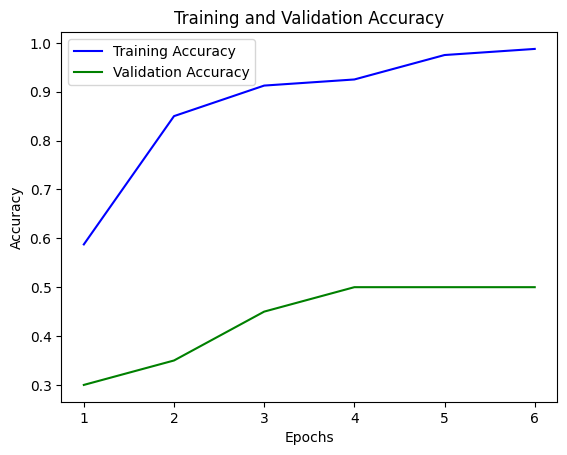


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6661 - accuracy: 0.6700
Test loss, Test accuracy: [0.6660618782043457, 0.6700000166893005]
4/4 [==============================] - 0s 44ms/step
AUC Accuracy Score: 0.7428



Current kl: 32
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.68999, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7240 - accuracy: 0.5125 - val_loss: 0.6900 - val_accuracy: 0.6500 - 3s/epoch - 595ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.68999 to 0.68925, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6463 - accuracy: 0.6750 - val_loss: 0.6893 - val_accuracy: 0.6000 - 369ms/epoch - 74ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.68925 to 0.68895, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6156 - accuracy: 0.7250 - val_loss: 0.6890 - val_accuracy: 0.6500 - 339ms/epoch - 68ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68895 to 0.68862, saving model t

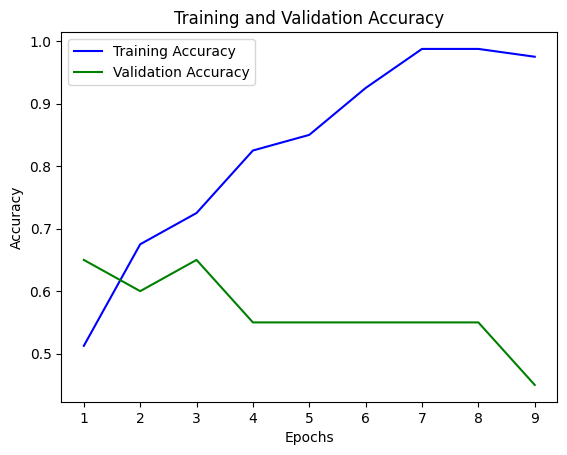


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6711 - accuracy: 0.6200
Test loss, Test accuracy: [0.671123743057251, 0.6200000047683716]
4/4 [==============================] - 0s 49ms/step
AUC Accuracy Score: 0.6619999999999999



Current kl: 64
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69037, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7037 - accuracy: 0.4375 - val_loss: 0.6904 - val_accuracy: 0.6000 - 4s/epoch - 778ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69037
5/5 - 0s - loss: 0.5827 - accuracy: 0.8250 - val_loss: 0.6922 - val_accuracy: 0.5500 - 383ms/epoch - 77ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69037
5/5 - 0s - loss: 0.4984 - accuracy: 0.9250 - val_loss: 0.6949 - val_accuracy: 0.5000 - 348ms/epoch - 70ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69037
5/5 - 0s - loss: 0.4348 - accuracy: 0.9750 - val_loss: 0.6999 - val_accuracy: 0.3000 - 3

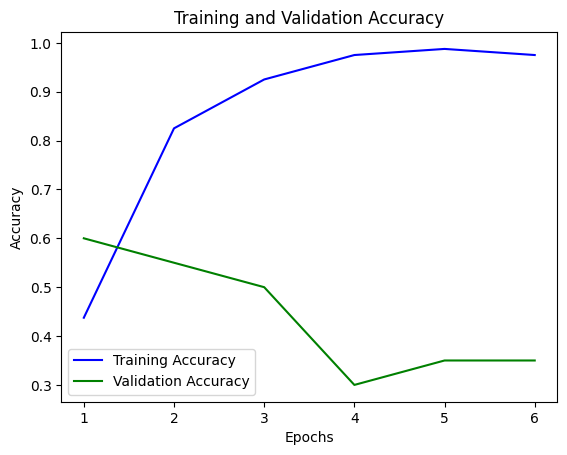


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6820 - accuracy: 0.5900
Test loss, Test accuracy: [0.6820307970046997, 0.5899999737739563]
4/4 [==============================] - 0s 36ms/step
AUC Accuracy Score: 0.5904



Current kl: 64
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69011, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7279 - accuracy: 0.5500 - val_loss: 0.6901 - val_accuracy: 0.5000 - 3s/epoch - 582ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69011
5/5 - 0s - loss: 0.5858 - accuracy: 0.8750 - val_loss: 0.6904 - val_accuracy: 0.4500 - 319ms/epoch - 64ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69011
5/5 - 0s - loss: 0.5278 - accuracy: 0.9625 - val_loss: 0.6946 - val_accuracy: 0.4000 - 308ms/epoch - 62ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69011
5/5 - 0s - loss: 0.4425 - accuracy: 0.9750 - val_loss: 0.6984 - val_accuracy: 0.4000 - 319ms/epoch

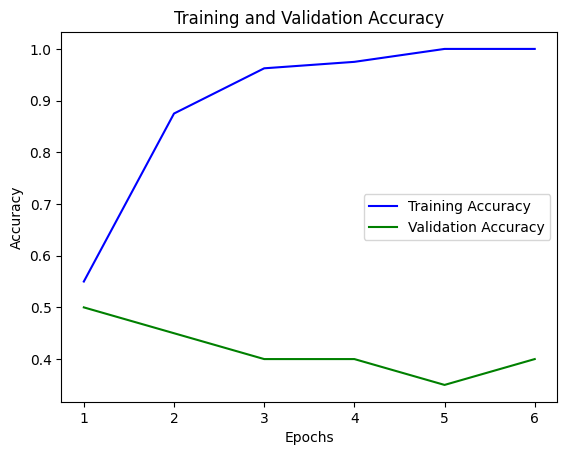


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6716 - accuracy: 0.5600
Test loss, Test accuracy: [0.6716128587722778, 0.5600000023841858]
4/4 [==============================] - 0s 52ms/step
AUC Accuracy Score: 0.6644



Current kl: 64
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69564, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.8128 - accuracy: 0.5500 - val_loss: 0.6956 - val_accuracy: 0.4000 - 4s/epoch - 788ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69564
5/5 - 0s - loss: 0.6479 - accuracy: 0.7625 - val_loss: 0.6977 - val_accuracy: 0.3500 - 336ms/epoch - 67ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69564
5/5 - 0s - loss: 0.6055 - accuracy: 0.7875 - val_loss: 0.7002 - val_accuracy: 0.4000 - 307ms/epoch - 61ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69564
5/5 - 0s - loss: 0.5503 - accuracy: 0.8375 - val_loss: 0.7025 - val_accuracy: 0.4500 - 315ms/epoch 

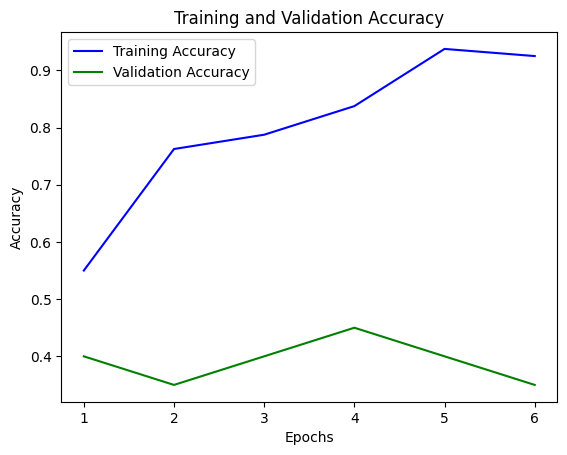


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6749 - accuracy: 0.6300
Test loss, Test accuracy: [0.6748889684677124, 0.6299999952316284]
4/4 [==============================] - 0s 43ms/step
AUC Accuracy Score: 0.6940000000000001



Current kl: 128
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69413, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7589 - accuracy: 0.3750 - val_loss: 0.6941 - val_accuracy: 0.5000 - 4s/epoch - 756ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69413
5/5 - 0s - loss: 0.5930 - accuracy: 0.7750 - val_loss: 0.6954 - val_accuracy: 0.5500 - 371ms/epoch - 74ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69413
5/5 - 0s - loss: 0.5209 - accuracy: 0.8750 - val_loss: 0.6968 - val_accuracy: 0.5500 - 360ms/epoch - 72ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69413
5/5 - 0s - loss: 0.4401 - accuracy: 0.9375 - val_loss: 0.6960 - val_accuracy: 0.5000 -

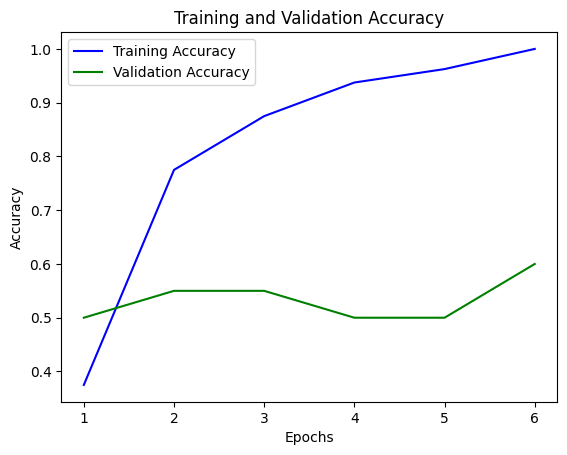


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6692 - accuracy: 0.7000
Test loss, Test accuracy: [0.6691611409187317, 0.699999988079071]
4/4 [==============================] - 0s 52ms/step
AUC Accuracy Score: 0.7196



Current kl: 128
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69467, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6849 - accuracy: 0.5500 - val_loss: 0.6947 - val_accuracy: 0.4500 - 3s/epoch - 670ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69467 to 0.69345, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5936 - accuracy: 0.8000 - val_loss: 0.6934 - val_accuracy: 0.6000 - 416ms/epoch - 83ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69345 to 0.69259, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5253 - accuracy: 0.8750 - val_loss: 0.6926 - val_accuracy: 0.5500 - 408ms/epoch - 82ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69259 to 0.69212, saving model 

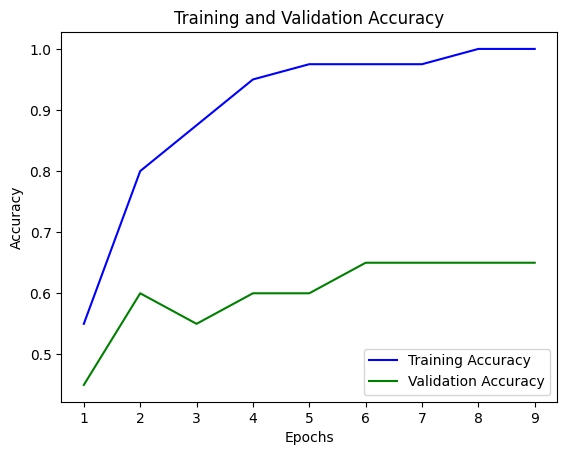


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6753 - accuracy: 0.5900
Test loss, Test accuracy: [0.6753469109535217, 0.5899999737739563]
4/4 [==============================] - 0s 40ms/step
AUC Accuracy Score: 0.6364



Current kl: 128
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69401, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7628 - accuracy: 0.4500 - val_loss: 0.6940 - val_accuracy: 0.5500 - 3s/epoch - 657ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69401
5/5 - 0s - loss: 0.6568 - accuracy: 0.6625 - val_loss: 0.6953 - val_accuracy: 0.5000 - 404ms/epoch - 81ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69401
5/5 - 0s - loss: 0.5920 - accuracy: 0.7875 - val_loss: 0.6964 - val_accuracy: 0.4500 - 409ms/epoch - 82ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69401
5/5 - 0s - loss: 0.5629 - accuracy: 0.8500 - val_loss: 0.6969 - val_accuracy: 0.4000 - 394ms/epoch

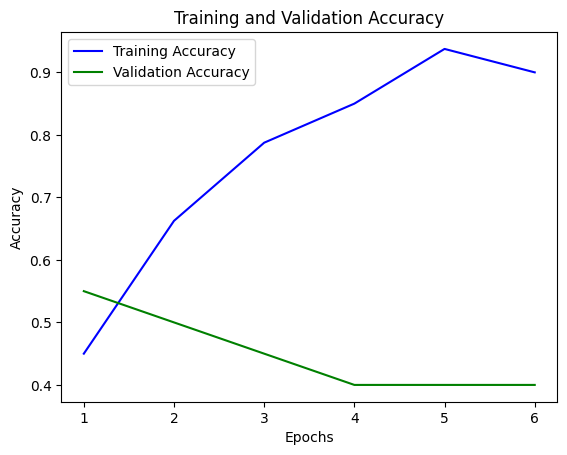


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6872 - accuracy: 0.5700
Test loss, Test accuracy: [0.6872220635414124, 0.5699999928474426]
4/4 [==============================] - 0s 44ms/step
AUC Accuracy Score: 0.6456


('feet_imagery', 'subtraction_imagery')
Highest AUC Score: 0.7428
Best kl value: 32
Best d value: 0.25


<ipython-input-6-9535703458ea>:149: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Event Pair': event_pair, 'AUC Score': highest_auc_score, 'kl': best_kl, 'd': best_d}, ignore_index=True)


Not setting metadata
100 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
Not setting metadata
100 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



y_train shape: (100, 2)
y_test shape: (100, 2)
X_train shape: (100, 1, 204, 2001)
X_test shape: (100, 1, 204, 2001)


Current kl: 8
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69307, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6932 - accuracy: 0.5125 - val_loss: 0.6931 - val_accuracy: 0.4500 - 3s/epoch - 594ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69307
5/5 - 0s - loss: 0.6006 - accuracy: 0.8750 - val_loss: 0.6933 - val_accuracy: 0.3000 - 294ms/epoch - 59ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69307
5/5 - 0s - loss: 0.5280 - accuracy: 0.9250 - val_loss: 0.6934 - val_accuracy: 0.4000 - 275ms/epoch - 55ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69307
5/5 - 0s - loss: 0.4523 - accuracy: 0.9625 - val_loss: 0.6941 - val_accuracy: 0.4000 - 304ms/epoch - 61ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.69307
5/5 - 0s - loss: 0.3988 - accuracy: 1.0000 - val_loss: 0.6952 - val_accur

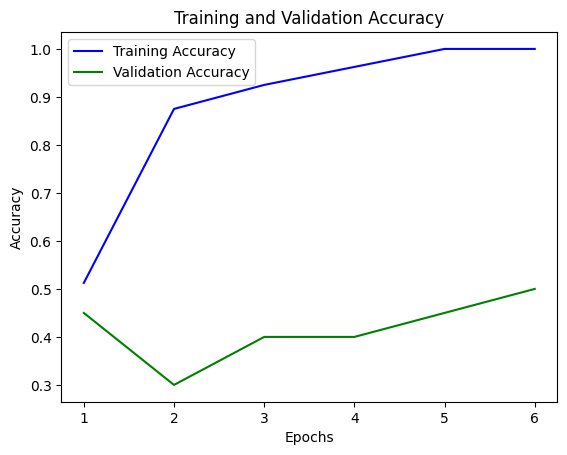


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6827 - accuracy: 0.6100
Test loss, Test accuracy: [0.6827013492584229, 0.6100000143051147]
4/4 [==============================] - 0s 35ms/step
AUC Accuracy Score: 0.6808000000000001



Current kl: 8
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69292, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.6973 - accuracy: 0.5125 - val_loss: 0.6929 - val_accuracy: 0.5000 - 4s/epoch - 773ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69292 to 0.69121, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6188 - accuracy: 0.8250 - val_loss: 0.6912 - val_accuracy: 0.5000 - 357ms/epoch - 71ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69121 to 0.68971, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5549 - accuracy: 0.9500 - val_loss: 0.6897 - val_accuracy: 0.5500 - 360ms/epoch - 72ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68971 to 0.68811, sa

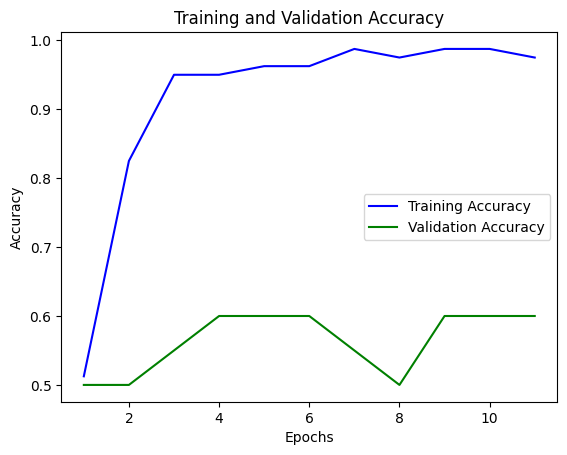


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6739 - accuracy: 0.6400
Test loss, Test accuracy: [0.673907458782196, 0.6399999856948853]
4/4 [==============================] - 0s 32ms/step
AUC Accuracy Score: 0.6776



Current kl: 8
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69369, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7437 - accuracy: 0.4375 - val_loss: 0.6937 - val_accuracy: 0.4500 - 3s/epoch - 574ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69369
5/5 - 0s - loss: 0.6614 - accuracy: 0.7000 - val_loss: 0.6945 - val_accuracy: 0.5000 - 301ms/epoch - 60ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69369
5/5 - 0s - loss: 0.5826 - accuracy: 0.8375 - val_loss: 0.6947 - val_accuracy: 0.4500 - 297ms/epoch - 59ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69369
5/5 - 0s - loss: 0.5442 - accuracy: 0.8625 - val_loss: 0.6953 - val_accuracy: 0.4500 - 345ms/epoch - 

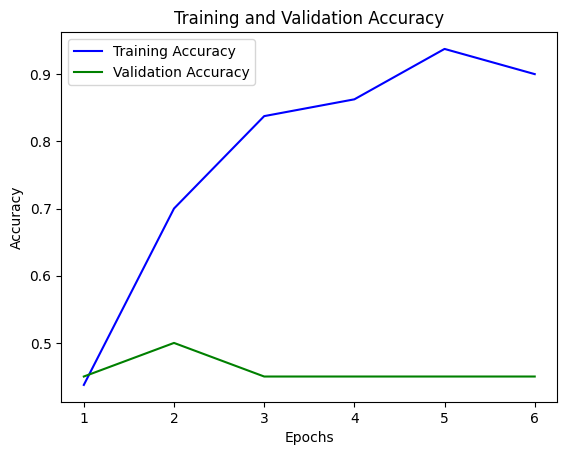


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6905 - accuracy: 0.5300
Test loss, Test accuracy: [0.690519392490387, 0.5299999713897705]
4/4 [==============================] - 0s 39ms/step
AUC Accuracy Score: 0.5472000000000001



Current kl: 16
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.68968, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6986 - accuracy: 0.5000 - val_loss: 0.6897 - val_accuracy: 0.6500 - 3s/epoch - 636ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.68968 to 0.68803, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5750 - accuracy: 0.8750 - val_loss: 0.6880 - val_accuracy: 0.7000 - 351ms/epoch - 70ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.68803 to 0.68792, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.4997 - accuracy: 0.9500 - val_loss: 0.6879 - val_accuracy: 0.7000 - 327ms/epoch - 65ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.68792
5/5 - 0s

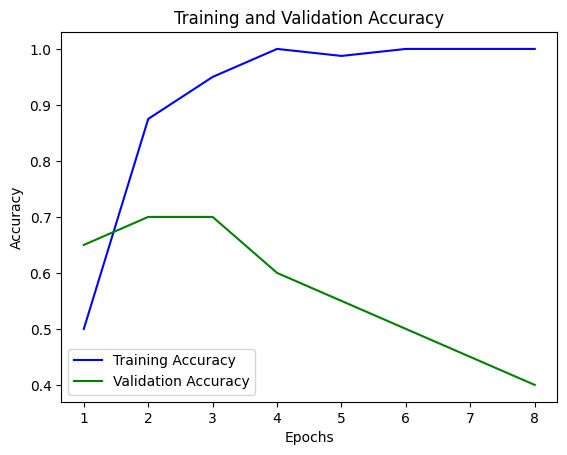


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6852 - accuracy: 0.5700
Test loss, Test accuracy: [0.6851655840873718, 0.5699999928474426]
4/4 [==============================] - 0s 37ms/step
AUC Accuracy Score: 0.5776



Current kl: 16
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69330, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7006 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5500 - 4s/epoch - 769ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69330 to 0.69310, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6157 - accuracy: 0.7000 - val_loss: 0.6931 - val_accuracy: 0.4500 - 429ms/epoch - 86ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69310 to 0.69277, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5406 - accuracy: 0.9000 - val_loss: 0.6928 - val_accuracy: 0.5000 - 412ms/epoch - 82ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69277 to 0.69268, saving model 

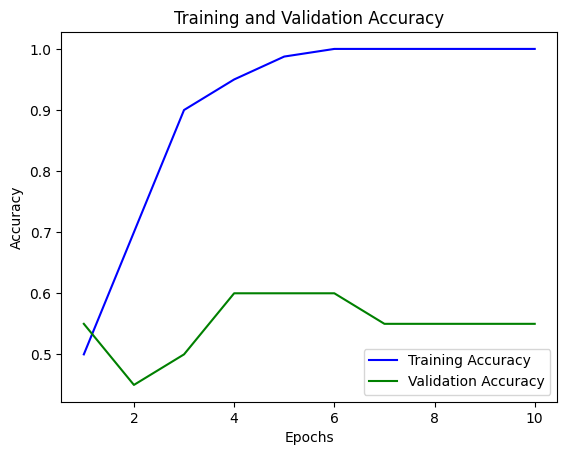


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6945 - accuracy: 0.5300
Test loss, Test accuracy: [0.694466769695282, 0.5299999713897705]
4/4 [==============================] - 0s 38ms/step
AUC Accuracy Score: 0.5232



Current kl: 16
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69307, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7700 - accuracy: 0.5125 - val_loss: 0.6931 - val_accuracy: 0.5500 - 3s/epoch - 578ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69307
5/5 - 0s - loss: 0.6392 - accuracy: 0.6750 - val_loss: 0.6933 - val_accuracy: 0.5500 - 337ms/epoch - 67ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69307
5/5 - 0s - loss: 0.6134 - accuracy: 0.7750 - val_loss: 0.6942 - val_accuracy: 0.5500 - 292ms/epoch - 58ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69307
5/5 - 0s - loss: 0.5641 - accuracy: 0.8750 - val_loss: 0.6953 - val_accuracy: 0.4500 - 310ms/epoch -

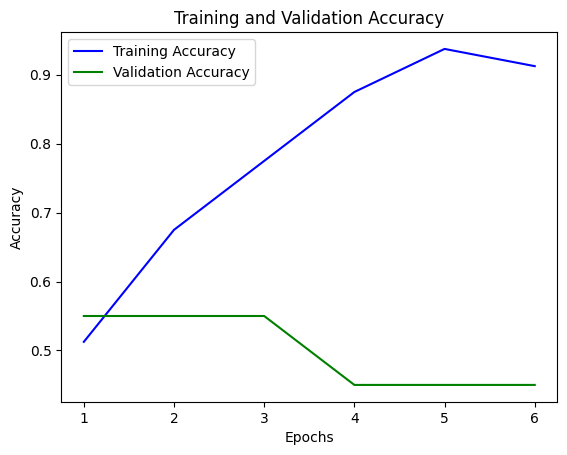


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6946 - accuracy: 0.4600
Test loss, Test accuracy: [0.6945647597312927, 0.46000000834465027]
4/4 [==============================] - 0s 41ms/step
AUC Accuracy Score: 0.47919999999999996



Current kl: 32
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69132, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7071 - accuracy: 0.5500 - val_loss: 0.6913 - val_accuracy: 0.6000 - 4s/epoch - 781ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69132 to 0.69014, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5893 - accuracy: 0.8250 - val_loss: 0.6901 - val_accuracy: 0.7000 - 358ms/epoch - 72ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69014 to 0.68741, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.4941 - accuracy: 0.9750 - val_loss: 0.6874 - val_accuracy: 0.6500 - 348ms/epoch - 70ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68741 to 0.68456, 

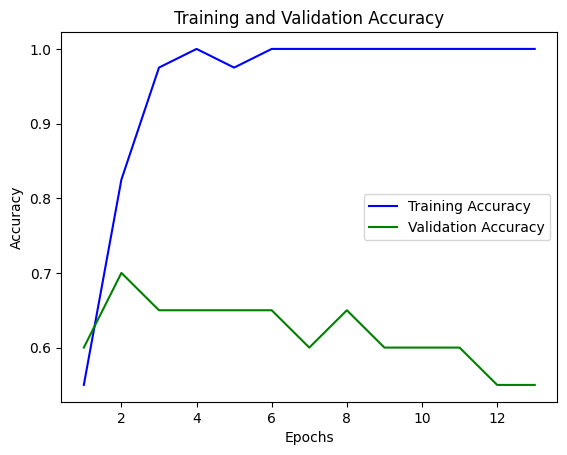


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6661 - accuracy: 0.6400
Test loss, Test accuracy: [0.6660581827163696, 0.6399999856948853]
4/4 [==============================] - 0s 53ms/step
AUC Accuracy Score: 0.6556



Current kl: 32
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69496, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7112 - accuracy: 0.5000 - val_loss: 0.6950 - val_accuracy: 0.5000 - 4s/epoch - 751ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69496
5/5 - 0s - loss: 0.6359 - accuracy: 0.7500 - val_loss: 0.6957 - val_accuracy: 0.4000 - 322ms/epoch - 64ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69496
5/5 - 0s - loss: 0.5586 - accuracy: 0.9125 - val_loss: 0.6965 - val_accuracy: 0.3500 - 291ms/epoch - 58ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69496
5/5 - 0s - loss: 0.5046 - accuracy: 0.9375 - val_loss: 0.6980 - val_accuracy: 0.3500 - 319ms/epoch

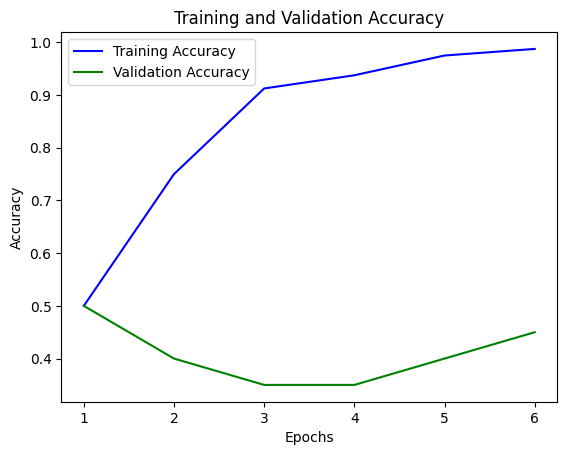


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6881 - accuracy: 0.5500
Test loss, Test accuracy: [0.6881145238876343, 0.550000011920929]
4/4 [==============================] - 0s 37ms/step
AUC Accuracy Score: 0.5880000000000001



Current kl: 32
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69319, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7096 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4000 - 3s/epoch - 577ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69319
5/5 - 0s - loss: 0.6439 - accuracy: 0.7000 - val_loss: 0.6940 - val_accuracy: 0.4000 - 317ms/epoch - 63ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69319
5/5 - 0s - loss: 0.5952 - accuracy: 0.7875 - val_loss: 0.6953 - val_accuracy: 0.4000 - 296ms/epoch - 59ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69319
5/5 - 0s - loss: 0.5688 - accuracy: 0.8625 - val_loss: 0.6960 - val_accuracy: 0.4000 - 3

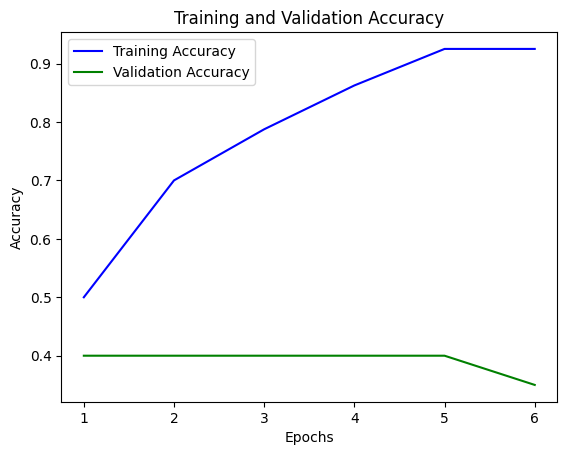


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6926 - accuracy: 0.5100
Test loss, Test accuracy: [0.6926212310791016, 0.5099999904632568]
4/4 [==============================] - 0s 39ms/step
AUC Accuracy Score: 0.51



Current kl: 64
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69187, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7252 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.5500 - 3s/epoch - 575ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69187
5/5 - 0s - loss: 0.6119 - accuracy: 0.8500 - val_loss: 0.6929 - val_accuracy: 0.4000 - 318ms/epoch - 64ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69187
5/5 - 0s - loss: 0.5183 - accuracy: 0.9625 - val_loss: 0.6937 - val_accuracy: 0.4500 - 335ms/epoch - 67ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69187
5/5 - 0s - loss: 0.4557 - accuracy: 1.0000 - val_loss: 0.6943 - val_accuracy: 0.4000 - 308ms/epoch - 

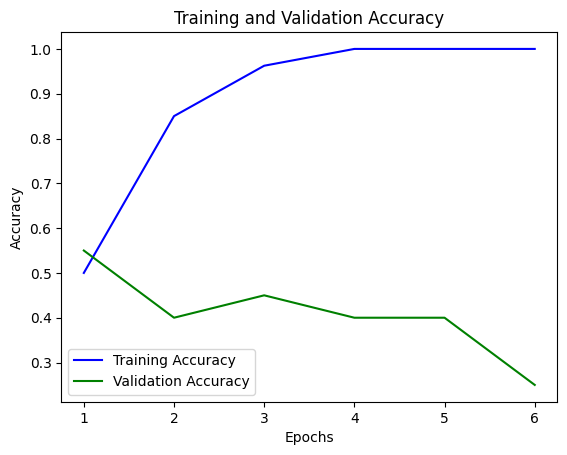


# Evaluate on test data
100/100 [==============================] - 1s 7ms/step - loss: 0.6780 - accuracy: 0.6200
Test loss, Test accuracy: [0.6779691576957703, 0.6200000047683716]
4/4 [==============================] - 0s 45ms/step
AUC Accuracy Score: 0.6739999999999999



Current kl: 64
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.68844, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7628 - accuracy: 0.5125 - val_loss: 0.6884 - val_accuracy: 0.7000 - 4s/epoch - 796ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.68844 to 0.68761, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6154 - accuracy: 0.8125 - val_loss: 0.6876 - val_accuracy: 0.7000 - 379ms/epoch - 76ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.68761 to 0.68612, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5575 - accuracy: 0.8750 - val_loss: 0.6861 - val_accuracy: 0.7000 - 392ms/epoch - 78ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68612 to 0.68586, s

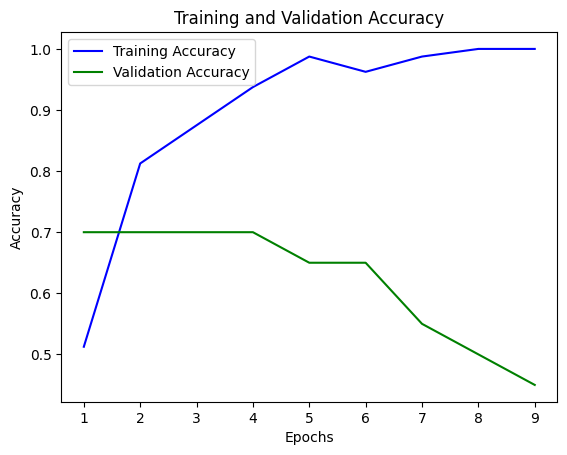


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6763 - accuracy: 0.6100
Test loss, Test accuracy: [0.6763342022895813, 0.6100000143051147]
4/4 [==============================] - 0s 35ms/step
AUC Accuracy Score: 0.6304



Current kl: 64
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69201, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.6732 - accuracy: 0.5500 - val_loss: 0.6920 - val_accuracy: 0.6000 - 4s/epoch - 730ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69201 to 0.69078, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6514 - accuracy: 0.6625 - val_loss: 0.6908 - val_accuracy: 0.6000 - 412ms/epoch - 82ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69078 to 0.68970, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5959 - accuracy: 0.7625 - val_loss: 0.6897 - val_accuracy: 0.5500 - 403ms/epoch - 81ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68970 to 0.68811, saving model t

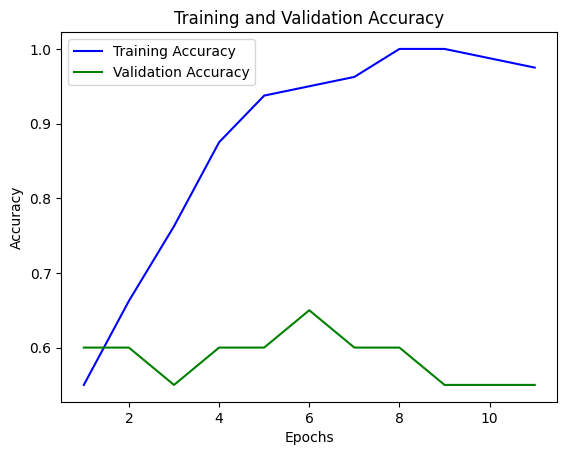


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6791 - accuracy: 0.5600
Test loss, Test accuracy: [0.6791027784347534, 0.5600000023841858]
4/4 [==============================] - 0s 41ms/step
AUC Accuracy Score: 0.5776



Current kl: 128
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69204, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7221 - accuracy: 0.5375 - val_loss: 0.6920 - val_accuracy: 0.5500 - 3s/epoch - 612ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69204 to 0.69139, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6015 - accuracy: 0.8125 - val_loss: 0.6914 - val_accuracy: 0.6000 - 423ms/epoch - 85ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69139 to 0.69044, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5189 - accuracy: 0.9250 - val_loss: 0.6904 - val_accuracy: 0.6000 - 449ms/epoch - 90ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69044 to 0.68950, saving model 

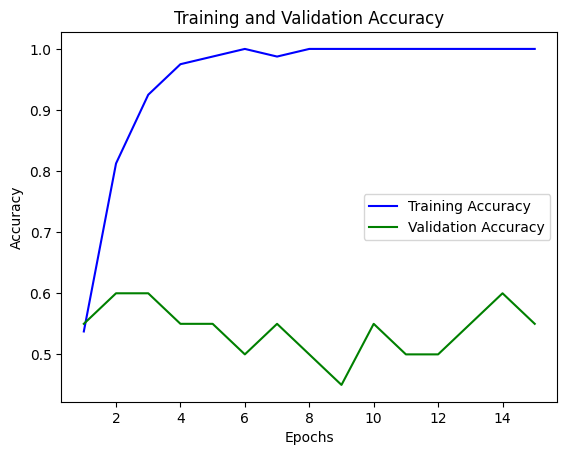


# Evaluate on test data
100/100 [==============================] - 1s 7ms/step - loss: 0.6800 - accuracy: 0.5700
Test loss, Test accuracy: [0.6800013780593872, 0.5699999928474426]
4/4 [==============================] - 0s 45ms/step
AUC Accuracy Score: 0.5935999999999999



Current kl: 128
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69422, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7616 - accuracy: 0.4625 - val_loss: 0.6942 - val_accuracy: 0.4500 - 3s/epoch - 591ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69422
5/5 - 0s - loss: 0.5823 - accuracy: 0.8375 - val_loss: 0.6962 - val_accuracy: 0.3500 - 360ms/epoch - 72ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69422
5/5 - 0s - loss: 0.5086 - accuracy: 0.8625 - val_loss: 0.6986 - val_accuracy: 0.3500 - 364ms/epoch - 73ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69422
5/5 - 0s - loss: 0.4418 - accuracy: 0.8875 - val_loss: 0.7011 - val_accuracy: 0.4000 

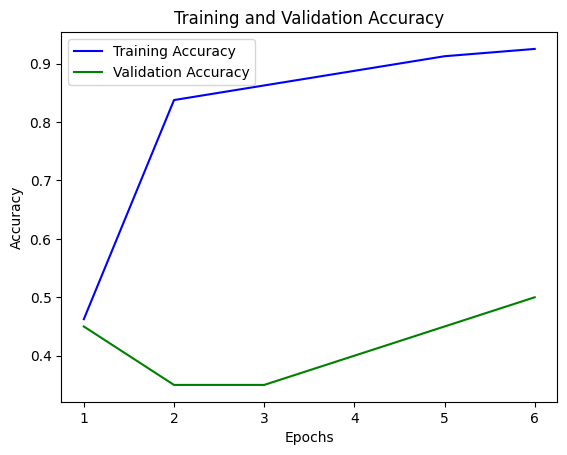


# Evaluate on test data
100/100 [==============================] - 1s 7ms/step - loss: 0.6791 - accuracy: 0.5400
Test loss, Test accuracy: [0.6791462898254395, 0.5400000214576721]
4/4 [==============================] - 0s 59ms/step
AUC Accuracy Score: 0.5820000000000001



Current kl: 128
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69304, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7315 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.4500 - 3s/epoch - 611ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69304 to 0.69299, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6296 - accuracy: 0.7250 - val_loss: 0.6930 - val_accuracy: 0.5500 - 416ms/epoch - 83ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69299
5/5 - 0s - loss: 0.5639 - accuracy: 0.8500 - val_loss: 0.6931 - val_accuracy: 0.5000 - 356ms/epoch - 71ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69299
5/5 - 0s - loss: 0.5369 - accuracy: 0.8625 - v

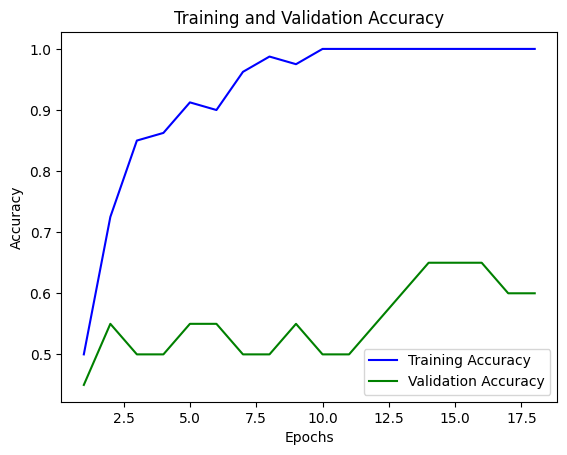


# Evaluate on test data
100/100 [==============================] - 1s 7ms/step - loss: 0.6798 - accuracy: 0.5800
Test loss, Test accuracy: [0.6798270344734192, 0.5799999833106995]
4/4 [==============================] - 1s 51ms/step
AUC Accuracy Score: 0.6144000000000001


('feet_imagery', 'word_imagery')
Highest AUC Score: 0.6808000000000001
Best kl value: 8
Best d value: 0.2


<ipython-input-6-9535703458ea>:149: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Event Pair': event_pair, 'AUC Score': highest_auc_score, 'kl': best_kl, 'd': best_d}, ignore_index=True)


Not setting metadata
100 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
Not setting metadata
100 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



y_train shape: (100, 2)
y_test shape: (100, 2)
X_train shape: (100, 1, 204, 2001)
X_test shape: (100, 1, 204, 2001)


Current kl: 8
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69084, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7001 - accuracy: 0.5750 - val_loss: 0.6908 - val_accuracy: 0.7500 - 3s/epoch - 626ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69084 to 0.68956, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6055 - accuracy: 0.8125 - val_loss: 0.6896 - val_accuracy: 0.7500 - 341ms/epoch - 68ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.68956 to 0.68850, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5253 - accuracy: 0.9500 - val_loss: 0.6885 - val_accuracy: 0.7500 - 333ms/epoch - 67ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68850 to 0.68747, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.4770 - accuracy: 0.9375 - val_loss: 0.6875 - val_accuracy: 0.7000 - 339ms/epoch - 68ms/step
Epoch 5/200



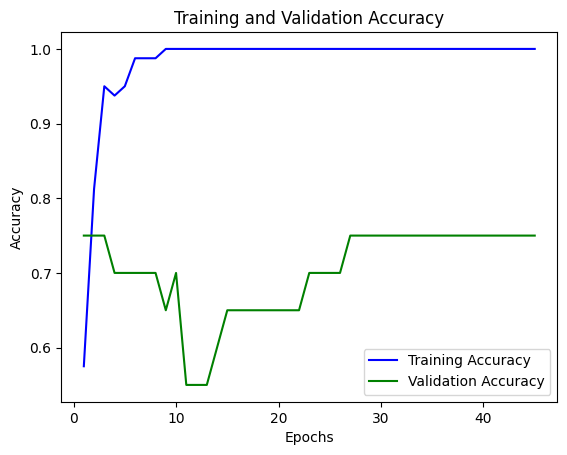


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.7529 - accuracy: 0.4700
Test loss, Test accuracy: [0.7529453039169312, 0.4699999988079071]
4/4 [==============================] - 0s 32ms/step
AUC Accuracy Score: 0.504



Current kl: 8
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69124, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7033 - accuracy: 0.5375 - val_loss: 0.6912 - val_accuracy: 0.6000 - 3s/epoch - 579ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69124 to 0.68989, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6005 - accuracy: 0.8500 - val_loss: 0.6899 - val_accuracy: 0.5500 - 374ms/epoch - 75ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.68989 to 0.68866, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5242 - accuracy: 0.9250 - val_loss: 0.6887 - val_accuracy: 0.6000 - 363ms/epoch - 73ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68866 to 0.68763, saving model to

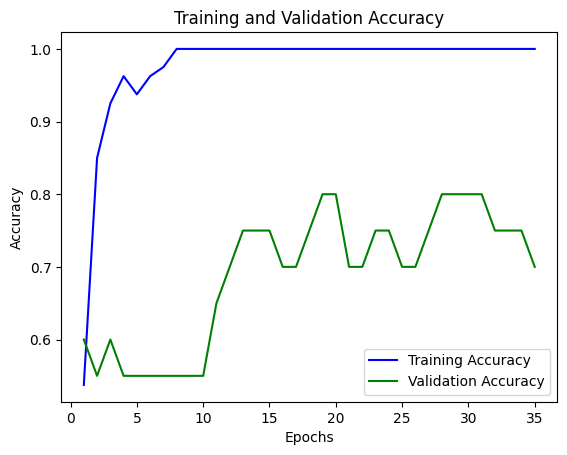


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.7730 - accuracy: 0.4500
Test loss, Test accuracy: [0.773033857345581, 0.44999998807907104]
4/4 [==============================] - 0s 33ms/step
AUC Accuracy Score: 0.4728



Current kl: 8
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69553, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7871 - accuracy: 0.4625 - val_loss: 0.6955 - val_accuracy: 0.5000 - 3s/epoch - 586ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69553
5/5 - 0s - loss: 0.6507 - accuracy: 0.6625 - val_loss: 0.6960 - val_accuracy: 0.4500 - 324ms/epoch - 65ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69553
5/5 - 0s - loss: 0.5776 - accuracy: 0.8000 - val_loss: 0.6964 - val_accuracy: 0.4500 - 324ms/epoch - 65ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69553
5/5 - 0s - loss: 0.5543 - accuracy: 0.8375 - val_loss: 0.6962 - val_accuracy: 0.4500 - 351ms/epoch -

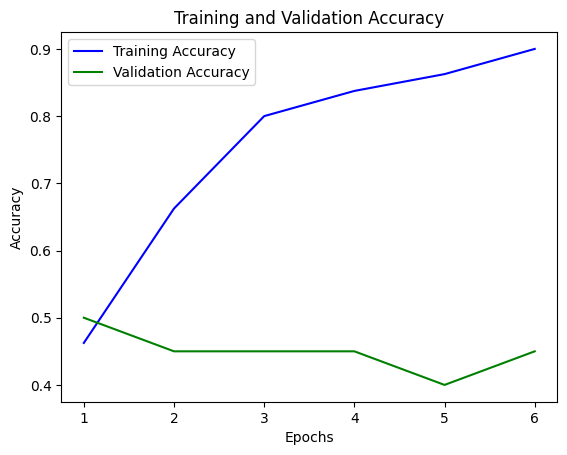


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.7028 - accuracy: 0.4600
Test loss, Test accuracy: [0.7027524709701538, 0.46000000834465027]
4/4 [==============================] - 0s 36ms/step
AUC Accuracy Score: 0.4132



Current kl: 16
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69326, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7162 - accuracy: 0.4750 - val_loss: 0.6933 - val_accuracy: 0.6000 - 3s/epoch - 603ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69326 to 0.69250, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6318 - accuracy: 0.8000 - val_loss: 0.6925 - val_accuracy: 0.6500 - 372ms/epoch - 74ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69250 to 0.69128, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5756 - accuracy: 0.8750 - val_loss: 0.6913 - val_accuracy: 0.5500 - 325ms/epoch - 65ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69128 to 0.69007, saving model 

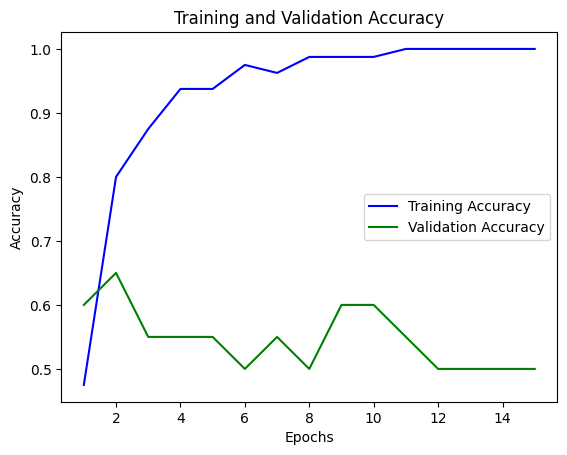


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6893 - accuracy: 0.5600
Test loss, Test accuracy: [0.6892662048339844, 0.5600000023841858]
4/4 [==============================] - 0s 48ms/step
AUC Accuracy Score: 0.5571999999999999



Current kl: 16
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69300, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6948 - accuracy: 0.5250 - val_loss: 0.6930 - val_accuracy: 0.4500 - 3s/epoch - 671ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69300 to 0.68836, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6081 - accuracy: 0.7875 - val_loss: 0.6884 - val_accuracy: 0.6500 - 370ms/epoch - 74ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.68836 to 0.68368, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5236 - accuracy: 0.9125 - val_loss: 0.6837 - val_accuracy: 0.6500 - 375ms/epoch - 75ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68368 to 0.67924, s

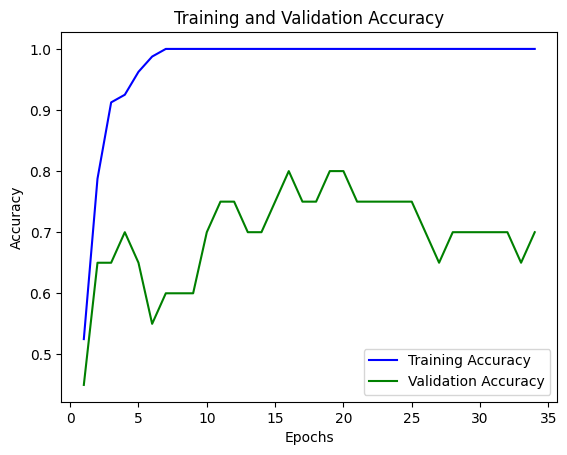


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.7166 - accuracy: 0.5200
Test loss, Test accuracy: [0.7165542840957642, 0.5199999809265137]
4/4 [==============================] - 0s 49ms/step
AUC Accuracy Score: 0.546



Current kl: 16
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69570, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7230 - accuracy: 0.5625 - val_loss: 0.6957 - val_accuracy: 0.4000 - 3s/epoch - 567ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69570 to 0.69554, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6436 - accuracy: 0.7375 - val_loss: 0.6955 - val_accuracy: 0.4000 - 365ms/epoch - 73ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69554
5/5 - 0s - loss: 0.5889 - accuracy: 0.8500 - val_loss: 0.6961 - val_accuracy: 0.4000 - 292ms/epoch - 58ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69554
5/5 - 0s - loss: 0.5497 - accuracy: 0.8500 - val_loss: 0.697

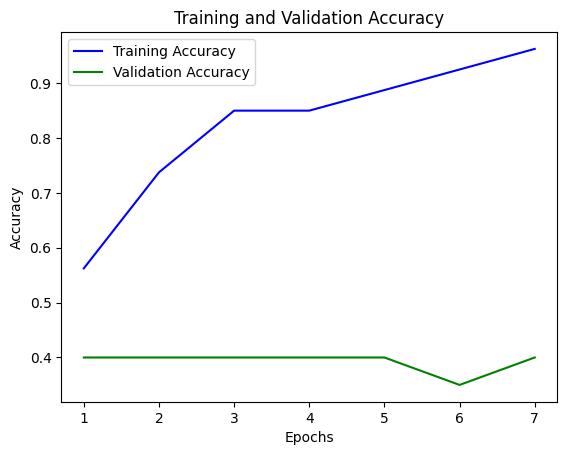


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.6964 - accuracy: 0.4400
Test loss, Test accuracy: [0.6963663697242737, 0.4399999976158142]
4/4 [==============================] - 0s 48ms/step
AUC Accuracy Score: 0.4628



Current kl: 32
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69175, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.6995 - accuracy: 0.5375 - val_loss: 0.6917 - val_accuracy: 0.6500 - 4s/epoch - 780ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69175
5/5 - 0s - loss: 0.6002 - accuracy: 0.7750 - val_loss: 0.6919 - val_accuracy: 0.5500 - 301ms/epoch - 60ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69175
5/5 - 0s - loss: 0.5270 - accuracy: 0.9375 - val_loss: 0.6920 - val_accuracy: 0.6500 - 321ms/epoch - 64ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69175
5/5 - 0s - loss: 0.4668 - accuracy: 0.9250 - val_loss: 0.6929 - val_accuracy: 0.6000 - 284ms/epoch 

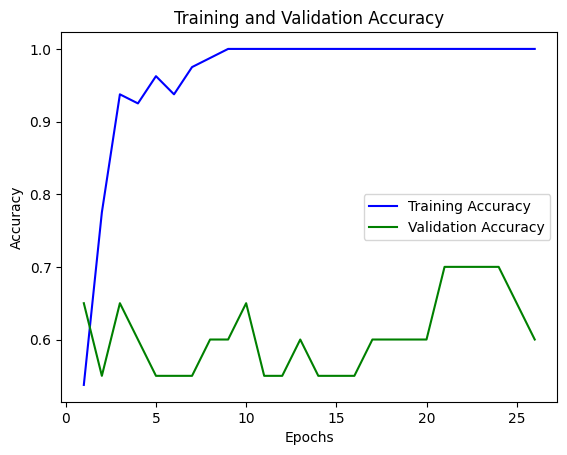


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.7553 - accuracy: 0.5100
Test loss, Test accuracy: [0.755330502986908, 0.5099999904632568]
4/4 [==============================] - 0s 43ms/step
AUC Accuracy Score: 0.49879999999999997



Current kl: 32
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.68972, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7060 - accuracy: 0.5250 - val_loss: 0.6897 - val_accuracy: 0.5500 - 3s/epoch - 675ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.68972 to 0.68614, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6214 - accuracy: 0.7500 - val_loss: 0.6861 - val_accuracy: 0.6500 - 399ms/epoch - 80ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.68614 to 0.68160, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.5527 - accuracy: 0.8500 - val_loss: 0.6816 - val_accuracy: 0.6500 - 384ms/epoch - 77ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68160 to 0.67639, s

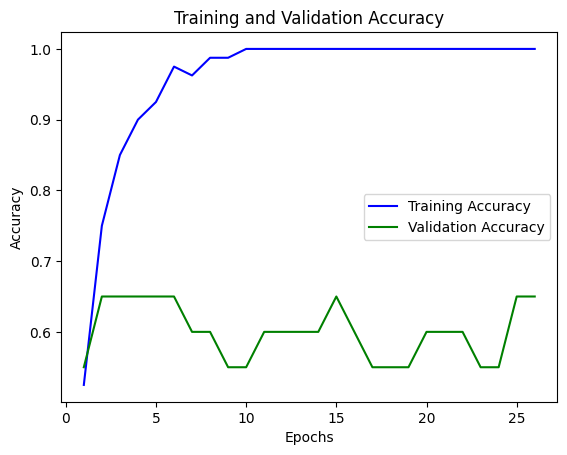


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.7762 - accuracy: 0.4800
Test loss, Test accuracy: [0.7761529684066772, 0.47999998927116394]
4/4 [==============================] - 0s 37ms/step
AUC Accuracy Score: 0.47239999999999993



Current kl: 32
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69333, saving model to /tmp/checkpoint.h5
5/5 - 4s - loss: 0.7562 - accuracy: 0.4625 - val_loss: 0.6933 - val_accuracy: 0.5000 - 4s/epoch - 822ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69333
5/5 - 0s - loss: 0.6592 - accuracy: 0.6375 - val_loss: 0.6936 - val_accuracy: 0.4500 - 301ms/epoch - 60ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69333
5/5 - 0s - loss: 0.6024 - accuracy: 0.7500 - val_loss: 0.6953 - val_accuracy: 0.4000 - 330ms/epoch - 66ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69333
5/5 - 0s - loss: 0.5904 - accuracy: 0.7000 - val_loss: 0.6972 - val_accuracy: 0.3500 

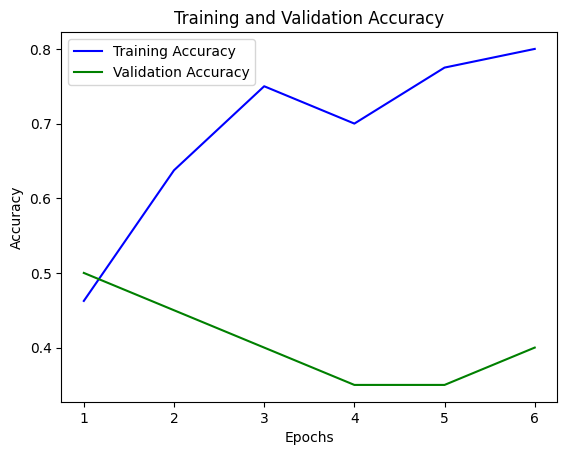


# Evaluate on test data
100/100 [==============================] - 1s 5ms/step - loss: 0.6978 - accuracy: 0.5000
Test loss, Test accuracy: [0.6977658271789551, 0.5]
4/4 [==============================] - 0s 35ms/step
AUC Accuracy Score: 0.47640000000000005



Current kl: 64
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69706, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.6927 - accuracy: 0.5250 - val_loss: 0.6971 - val_accuracy: 0.3000 - 3s/epoch - 571ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.69706
5/5 - 0s - loss: 0.5785 - accuracy: 0.8125 - val_loss: 0.6996 - val_accuracy: 0.3000 - 347ms/epoch - 69ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69706
5/5 - 0s - loss: 0.4946 - accuracy: 0.8375 - val_loss: 0.7023 - val_accuracy: 0.3000 - 330ms/epoch - 66ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69706
5/5 - 0s - loss: 0.4217 - accuracy: 0.9375 - val_loss: 0.7080 - val_accuracy: 0.3500 - 313ms/epoch - 

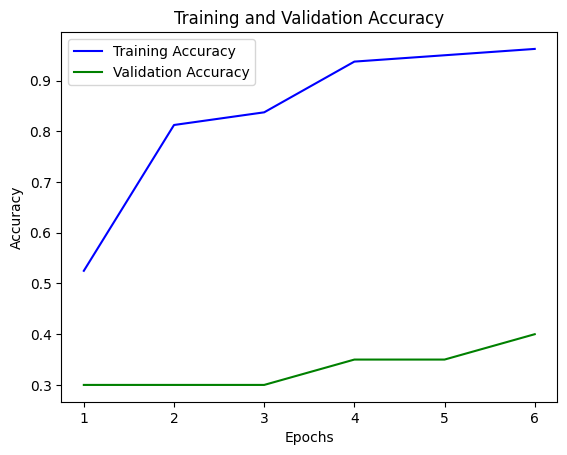


# Evaluate on test data
100/100 [==============================] - 1s 7ms/step - loss: 0.7014 - accuracy: 0.4500
Test loss, Test accuracy: [0.7014168500900269, 0.44999998807907104]
4/4 [==============================] - 0s 48ms/step
AUC Accuracy Score: 0.45120000000000005



Current kl: 64
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69289, saving model to /tmp/checkpoint.h5
5/5 - 3s - loss: 0.7235 - accuracy: 0.5375 - val_loss: 0.6929 - val_accuracy: 0.5000 - 3s/epoch - 606ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69289 to 0.69180, saving model to /tmp/checkpoint.h5
5/5 - 0s - loss: 0.6027 - accuracy: 0.7875 - val_loss: 0.6918 - val_accuracy: 0.5000 - 380ms/epoch - 76ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.69180
5/5 - 0s - loss: 0.5149 - accuracy: 0.8750 - val_loss: 0.6918 - val_accuracy: 0.5000 - 309ms/epoch - 62ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.69180
5/5 - 0s - loss: 0.4398 - accuracy: 0.9250 -

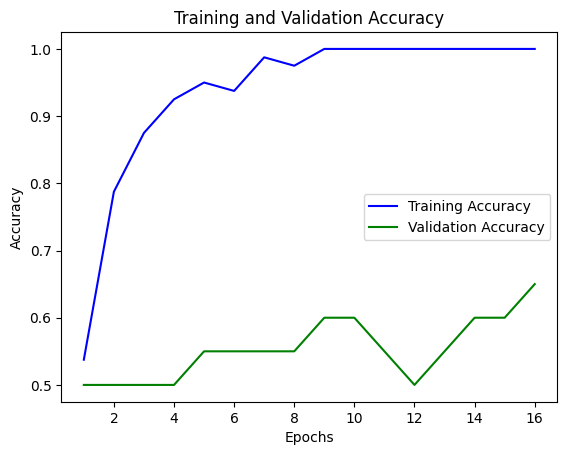


# Evaluate on test data
100/100 [==============================] - 1s 6ms/step - loss: 0.7292 - accuracy: 0.5100
Test loss, Test accuracy: [0.7292041182518005, 0.5099999904632568]
4/4 [==============================] - 0s 52ms/step
AUC Accuracy Score: 0.514



Current kl: 64
Current d: 0.5

Epoch 1/200


In [ ]:
# Iterate over the event pairs
for event_pair in event_pairs:
    event_id_1 = event_id[event_pair[0]]
    event_id_2 = event_id[event_pair[1]]

    # Find the indices of the events for the first event ID in training epochs
    event_indices_train_1 = np.where(epochs_train.events[:, -1] == event_id_1)[0]
    # Find the indices of the events for the second event ID in training epochs
    event_indices_train_2 = np.where(epochs_train.events[:, -1] == event_id_2)[0]

    # Select the epochs for the first event ID from training epochs
    epochs_train_1 = epochs_train[event_indices_train_1]
    # Select the epochs for the second event ID from training epochs
    epochs_train_2 = epochs_train[event_indices_train_2]

    # Find the indices of the events for the first event ID in testing epochs
    event_indices_test_1 = np.where(epochs_test.events[:, -1] == event_id_1)[0]
    # Find the indices of the events for the second event ID in testing epochs
    event_indices_test_2 = np.where(epochs_test.events[:, -1] == event_id_2)[0]

    # Select the epochs for the first event ID from testing epochs
    epochs_test_1 = epochs_test[event_indices_test_1]
    # Select the epochs for the second event ID from testing epochs
    epochs_test_2 = epochs_test[event_indices_test_2]

    # If you want to work with both events together, you can concatenate them
    concatenated_epochs_train = mne.concatenate_epochs([epochs_train_1, epochs_train_2])
    concatenated_epochs_test = mne.concatenate_epochs([epochs_test_1, epochs_test_2])

    # Do something with the concatenated training and testing epochs
    # For example, you can perform averaging or statistical analyses

    # Assign X_train, y_train, X_test, and y_test variables for the current event pair
    X_train = concatenated_epochs_train.get_data()
    y_train = concatenated_epochs_train.events[:, -1]

    X_test = concatenated_epochs_test.get_data()
    y_test = concatenated_epochs_test.events[:, -1]

    # Shuffle the training set
    X_train, y_train = shuffle(X_train, y_train)

    # Compute mean and standard deviation of the training data
    train_mean = np.mean(X_train)
    train_std = np.std(X_train)

    # Normalize the training data
    X_train = (X_train - train_mean) / train_std

    # Normalize the testing data using the mean and standard deviation of the training data
    X_test = (X_test - train_mean) / train_std

    # Reshape the data to match EEGNet input format
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

    # Band Pass Filtering
    # print()
    # print('Band Pass Filtering...')
    # X_train = mne.filter.filter_data(X_train, fs, l_freq=8, h_freq=30)
    # X_test = mne.filter.filter_data(X_test, fs, l_freq=8, h_freq=30)

    # Convert labels to one-hot encodings
    encoder = OneHotEncoder(sparse=False)
    y_train = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test = encoder.transform(y_test.reshape(-1, 1))

    # Update the nb_classes parameter in the EEGNet function
    nb_classes = y_train.shape[1]
    print()
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print()
    # Initialize variables to store the highest AUC score and corresponding kl value
    highest_auc_score = 0
    best_kl = None
    best_d = None
    # Iterate over the kl and d values
    for kl in kl_values:
        for d in d_values:
            print()
            print("Current kl:", kl)
            print("Current d:", d)
            print()

            # Configure the EEGNet model
            model = EEGNet(nb_classes=nb_classes, Chans=X_train.shape[2], Samples=X_train.shape[3], dropoutRate=d, kernLength=kl)

            # Compile the model
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            # Set a valid path for model checkpoints
            checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

            # Class weights
            class_weights = {0: 1, 1: 1}

            # Fit the model to the training data
            history = model.fit(X_train, y_train, batch_size=16, epochs=n_epochs, verbose=2,
                                validation_split=0.2, callbacks=[checkpointer, EarlyStopping(patience=5)], class_weight=class_weights)

            # Access the accuracy values from the history object
            train_accuracy = history.history['accuracy']
            val_accuracy = history.history['val_accuracy']

            # Plot the training and validation accuracy
            epochs = range(1, len(train_accuracy) + 1)
            plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
            plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()

            print('\n# Evaluate on test data')
            results = model.evaluate(X_test, y_test, batch_size=1)
            print('Test loss, Test accuracy:', results)

            # Evaluate the model on the test data
            y_pred = model.predict(X_test)
            auc_score = roc_auc_score(y_test, y_pred)
            # Print the AUC accuracy score
            print('AUC Accuracy Score:', auc_score)

            # Check if the current AUC score is higher than the highest recorded score
            if auc_score > highest_auc_score:
                highest_auc_score = auc_score
                best_kl = kl
                best_d = d

            # Reset the Keras session to clear the model
            K.clear_session()

            print()
            print('=' * 100)
            print('=' * 100)
            print()

    # Print the event pair, highest AUC score, kl value, and d value
    print(event_pair)
    print("Highest AUC Score:", highest_auc_score)
    print("Best kl value:", best_kl)
    print("Best d value:", best_d)

    # Append the results to the DataFrame
    results_df = results_df.append({'Event Pair': event_pair, 'AUC Score': highest_auc_score, 'kl': best_kl, 'd': best_d}, ignore_index=True)

# Save the highest AUC score and the corresponding kl value to a file
np.save(out_f_name, {'auc_score': highest_auc_score, 'kl_value': best_kl})

# Print the final results table
print(results_df)

# **ShallowConvNet**

In [ ]:
# Iterate over the event pairs
for event_pair in event_pairs:
    event_id_1 = event_id[event_pair[0]]
    event_id_2 = event_id[event_pair[1]]

    # Find the indices of the events for the first event ID in training epochs
    event_indices_train_1 = np.where(epochs_train.events[:, -1] == event_id_1)[0]
    # Find the indices of the events for the second event ID in training epochs
    event_indices_train_2 = np.where(epochs_train.events[:, -1] == event_id_2)[0]

    # Select the epochs for the first event ID from training epochs
    epochs_train_1 = epochs_train[event_indices_train_1]
    # Select the epochs for the second event ID from training epochs
    epochs_train_2 = epochs_train[event_indices_train_2]

    # Find the indices of the events for the first event ID in testing epochs
    event_indices_test_1 = np.where(epochs_test.events[:, -1] == event_id_1)[0]
    # Find the indices of the events for the second event ID in testing epochs
    event_indices_test_2 = np.where(epochs_test.events[:, -1] == event_id_2)[0]

    # Select the epochs for the first event ID from testing epochs
    epochs_test_1 = epochs_test[event_indices_test_1]
    # Select the epochs for the second event ID from testing epochs
    epochs_test_2 = epochs_test[event_indices_test_2]

    # If you want to work with both events together, you can concatenate them
    concatenated_epochs_train = mne.concatenate_epochs([epochs_train_1, epochs_train_2])
    concatenated_epochs_test = mne.concatenate_epochs([epochs_test_1, epochs_test_2])

    # Do something with the concatenated training and testing epochs
    # For example, you can perform averaging or statistical analyses

    # Assign X_train, y_train, X_test, and y_test variables for the current event pair
    X_train = concatenated_epochs_train.get_data()
    y_train = concatenated_epochs_train.events[:, -1]

    X_test = concatenated_epochs_test.get_data()
    y_test = concatenated_epochs_test.events[:, -1]

    # Shuffle the training set
    X_train, y_train = shuffle(X_train, y_train)

    # Compute mean and standard deviation of the training data
    train_mean = np.mean(X_train)
    train_std = np.std(X_train)

    # Normalize the training data
    X_train = (X_train - train_mean) / train_std

    # Normalize the testing data using the mean and standard deviation of the training data
    X_test = (X_test - train_mean) / train_std

    # Reshape the data to match EEGNet input format
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

    # Band Pass Filtering
    print()
    print('Band Pass Filtering...')
    X_train = mne.filter.filter_data(X_train, fs, l_freq=8, h_freq=30)
    X_test = mne.filter.filter_data(X_test, fs, l_freq=8, h_freq=30)

    # Convert labels to one-hot encodings
    encoder = OneHotEncoder(sparse=False)
    y_train = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test = encoder.transform(y_test.reshape(-1, 1))

    # Update the nb_classes parameter in the EEGNet function
    nb_classes = y_train.shape[1]
    print()
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print()

    # Iterate over the kl and d values
    for kl in kl_values:
        for d in d_values:
            print()
            print("Current kl:", kl)
            print("Current d:", d)
            print()

            # Configure the EEGNet model
            model = ShallowConvNet(nb_classes=nb_classes, Chans=X_train.shape[2], Samples=X_train.shape[3], dropoutRate=d, kernLength=kl)

            # Compile the model
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            # Set a valid path for model checkpoints
            checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

            # Class weights
            class_weights = {0: 1, 1: 1}

            # Fit the model to the training data
            history = model.fit(X_train, y_train, batch_size=16, epochs=n_epochs, verbose=2,
                                validation_split=0.2, callbacks=[checkpointer, EarlyStopping(patience=5)], class_weight=class_weights)

            # Access the accuracy values from the history object
            train_accuracy = history.history['accuracy']
            val_accuracy = history.history['val_accuracy']

            # Plot the training and validation accuracy
            epochs = range(1, len(train_accuracy) + 1)
            plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
            plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()

            print('\n# Evaluate on test data')
            results = model.evaluate(X_test, y_test, batch_size=1)
            print('Test loss, Test accuracy:', results)

            # Evaluate the model on the test data
            y_pred = model.predict(X_test)
            auc_score = roc_auc_score(y_test, y_pred)
            # Print the AUC accuracy score
            print('AUC Accuracy Score:', auc_score)

            # Check if the current AUC score is higher than the highest recorded score
            if auc_score > highest_auc_score:
                highest_auc_score = auc_score
                best_kl = kl
                best_d = d

            # Reset the Keras session to clear the model
            K.clear_session()

            print()
            print('=' * 100)
            print('=' * 100)
            print()

    # Print the event pair, highest AUC score, kl value, and d value
    print(event_pair)
    print("Highest AUC Score:", highest_auc_score)
    print("Best kl value:", best_kl)
    print("Best d value:", best_d)

    # Append the results to the DataFrame
    results_df = results_df.append({'Event Pair': event_pair, 'AUC Score': highest_auc_score, 'kl': best_kl, 'd': best_d}, ignore_index=True)

# Save the highest AUC score and the corresponding kl value to a file
np.save(out_f_name, {'auc_score': highest_auc_score, 'kl_value': best_kl})

# Print the final results table
print(results_df)

# **DeepConvNet**

In [ ]:
# Iterate over the event pairs
for event_pair in event_pairs:
    event_id_1 = event_id[event_pair[0]]
    event_id_2 = event_id[event_pair[1]]

    # Find the indices of the events for the first event ID in training epochs
    event_indices_train_1 = np.where(epochs_train.events[:, -1] == event_id_1)[0]
    # Find the indices of the events for the second event ID in training epochs
    event_indices_train_2 = np.where(epochs_train.events[:, -1] == event_id_2)[0]

    # Select the epochs for the first event ID from training epochs
    epochs_train_1 = epochs_train[event_indices_train_1]
    # Select the epochs for the second event ID from training epochs
    epochs_train_2 = epochs_train[event_indices_train_2]

    # Find the indices of the events for the first event ID in testing epochs
    event_indices_test_1 = np.where(epochs_test.events[:, -1] == event_id_1)[0]
    # Find the indices of the events for the second event ID in testing epochs
    event_indices_test_2 = np.where(epochs_test.events[:, -1] == event_id_2)[0]

    # Select the epochs for the first event ID from testing epochs
    epochs_test_1 = epochs_test[event_indices_test_1]
    # Select the epochs for the second event ID from testing epochs
    epochs_test_2 = epochs_test[event_indices_test_2]

    # If you want to work with both events together, you can concatenate them
    concatenated_epochs_train = mne.concatenate_epochs([epochs_train_1, epochs_train_2])
    concatenated_epochs_test = mne.concatenate_epochs([epochs_test_1, epochs_test_2])

    # Do something with the concatenated training and testing epochs
    # For example, you can perform averaging or statistical analyses

    # Assign X_train, y_train, X_test, and y_test variables for the current event pair
    X_train = concatenated_epochs_train.get_data()
    y_train = concatenated_epochs_train.events[:, -1]

    X_test = concatenated_epochs_test.get_data()
    y_test = concatenated_epochs_test.events[:, -1]

    # Shuffle the training set
    X_train, y_train = shuffle(X_train, y_train)

    # Compute mean and standard deviation of the training data
    train_mean = np.mean(X_train)
    train_std = np.std(X_train)

    # Normalize the training data
    X_train = (X_train - train_mean) / train_std

    # Normalize the testing data using the mean and standard deviation of the training data
    X_test = (X_test - train_mean) / train_std

    # Reshape the data to match EEGNet input format
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

    # Band Pass Filtering
    print()
    print('Band Pass Filtering...')
    X_train = mne.filter.filter_data(X_train, fs, l_freq=8, h_freq=30)
    X_test = mne.filter.filter_data(X_test, fs, l_freq=8, h_freq=30)

    # Convert labels to one-hot encodings
    encoder = OneHotEncoder(sparse=False)
    y_train = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test = encoder.transform(y_test.reshape(-1, 1))

    # Update the nb_classes parameter in the EEGNet function
    nb_classes = y_train.shape[1]
    print()
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print()

    # Iterate over the kl and d values
    for kl in kl_values:
        for d in d_values:
            print()
            print("Current kl:", kl)
            print("Current d:", d)
            print()

            # Configure the EEGNet model
            model = DeepConvNet(nb_classes=nb_classes, Chans=X_train.shape[2], Samples=X_train.shape[3], dropoutRate=d, kernLength=kl)

            # Compile the model
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            # Set a valid path for model checkpoints
            checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

            # Class weights
            class_weights = {0: 1, 1: 1}

            # Fit the model to the training data
            history = model.fit(X_train, y_train, batch_size=16, epochs=n_epochs, verbose=2,
                                validation_split=0.2, callbacks=[checkpointer, EarlyStopping(patience=5)], class_weight=class_weights)

            # Access the accuracy values from the history object
            train_accuracy = history.history['accuracy']
            val_accuracy = history.history['val_accuracy']

            # Plot the training and validation accuracy
            epochs = range(1, len(train_accuracy) + 1)
            plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
            plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()

            print('\n# Evaluate on test data')
            results = model.evaluate(X_test, y_test, batch_size=1)
            print('Test loss, Test accuracy:', results)

            # Evaluate the model on the test data
            y_pred = model.predict(X_test)
            auc_score = roc_auc_score(y_test, y_pred)
            # Print the AUC accuracy score
            print('AUC Accuracy Score:', auc_score)

            # Check if the current AUC score is higher than the highest recorded score
            if auc_score > highest_auc_score:
                highest_auc_score = auc_score
                best_kl = kl
                best_d = d

            # Reset the Keras session to clear the model
            K.clear_session()

            print()
            print('=' * 100)
            print('=' * 100)
            print()

    # Print the event pair, highest AUC score, kl value, and d value
    print(event_pair)
    print("Highest AUC Score:", highest_auc_score)
    print("Best kl value:", best_kl)
    print("Best d value:", best_d)

    # Append the results to the DataFrame
    results_df = results_df.append({'Event Pair': event_pair, 'AUC Score': highest_auc_score, 'kl': best_kl, 'd': best_d}, ignore_index=True)

# Save the highest AUC score and the corresponding kl value to a file
np.save(out_f_name, {'auc_score': highest_auc_score, 'kl_value': best_kl})

# Print the final results table
print(results_df)

# **MEGNet (Multi-Class)**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



y_train shape: (200, 4)
y_test shape: (200, 4)
X_train shape: (200, 1, 204, 2001)
X_test shape: (200, 1, 204, 2001)


Current kl: 8
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38744, saving model to /tmp/checkpoint.h5
10/10 - 13s - loss: 1.4017 - accuracy: 0.2313 - val_loss: 1.3874 - val_accuracy: 0.2000 - 13s/epoch - 1s/step
Epoch 2/200

Epoch 2: val_loss improved from 1.38744 to 1.38534, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2383 - accuracy: 0.5875 - val_loss: 1.3853 - val_accuracy: 0.2750 - 567ms/epoch - 57ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.38534 to 1.38385, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.1139 - accuracy: 0.8313 - val_loss: 1.3838 - val_accuracy: 0.3000 - 618ms/epoch - 62ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.38385 to 1.38177, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.0079 - accuracy: 0.9000 - val_loss: 1.3818 - val_accuracy: 0.2500 - 537ms/epoch - 54ms/step
Epoch 

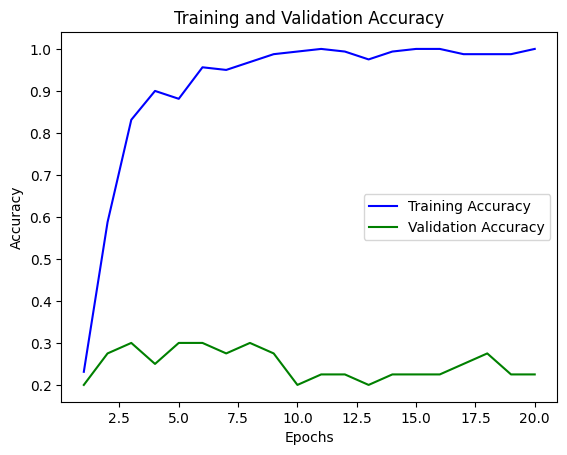


# Evaluate on test data
200/200 [==============================] - 1s 6ms/step - loss: 1.2395 - accuracy: 0.4400
Test loss, Test accuracy: [1.2394758462905884, 0.4399999976158142]
7/7 [==============================] - 1s 31ms/step
AUC Accuracy Score: 0.7405999999999999



Current kl: 8
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38622, saving model to /tmp/checkpoint.h5
10/10 - 3s - loss: 1.4163 - accuracy: 0.2250 - val_loss: 1.3862 - val_accuracy: 0.2250 - 3s/epoch - 309ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 1.38622
10/10 - 0s - loss: 1.2543 - accuracy: 0.5500 - val_loss: 1.3868 - val_accuracy: 0.1250 - 494ms/epoch - 49ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 1.38622
10/10 - 0s - loss: 1.1287 - accuracy: 0.7500 - val_loss: 1.3875 - val_accuracy: 0.1750 - 487ms/epoch - 49ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 1.38622
10/10 - 0s - loss: 1.0555 - accuracy: 0.8188 - val_loss: 1.3898 - val_accuracy: 0

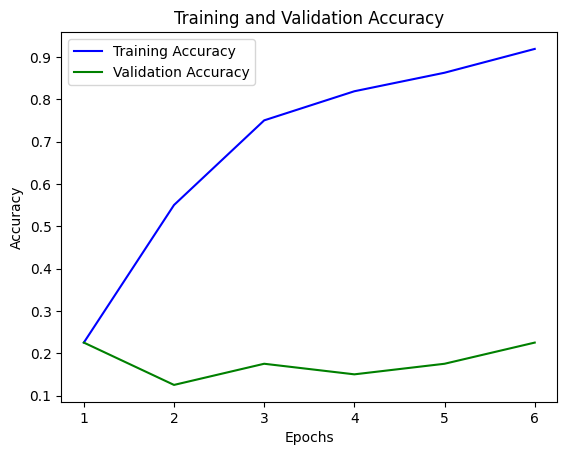


# Evaluate on test data
200/200 [==============================] - 1s 5ms/step - loss: 1.3750 - accuracy: 0.2850
Test loss, Test accuracy: [1.3749608993530273, 0.2849999964237213]
7/7 [==============================] - 1s 50ms/step
AUC Accuracy Score: 0.5802666666666667



Current kl: 8
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38937, saving model to /tmp/checkpoint.h5
10/10 - 3s - loss: 1.3969 - accuracy: 0.2688 - val_loss: 1.3894 - val_accuracy: 0.1500 - 3s/epoch - 316ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 1.38937
10/10 - 1s - loss: 1.3174 - accuracy: 0.4125 - val_loss: 1.3901 - val_accuracy: 0.1500 - 575ms/epoch - 57ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 1.38937
10/10 - 0s - loss: 1.2362 - accuracy: 0.5437 - val_loss: 1.3898 - val_accuracy: 0.1750 - 498ms/epoch - 50ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.38937 to 1.38921, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.1629 - accuracy: 0.68

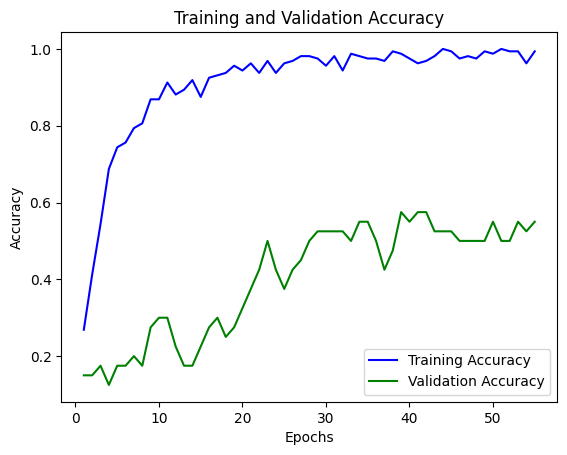


# Evaluate on test data
200/200 [==============================] - 1s 4ms/step - loss: 1.0645 - accuracy: 0.5000
Test loss, Test accuracy: [1.0644739866256714, 0.5]
7/7 [==============================] - 0s 36ms/step
AUC Accuracy Score: 0.8033333333333332



Current kl: 16
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38752, saving model to /tmp/checkpoint.h5
10/10 - 5s - loss: 1.4043 - accuracy: 0.2500 - val_loss: 1.3875 - val_accuracy: 0.1250 - 5s/epoch - 494ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.38752 to 1.38544, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2428 - accuracy: 0.5813 - val_loss: 1.3854 - val_accuracy: 0.3000 - 692ms/epoch - 69ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.38544 to 1.38222, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.1251 - accuracy: 0.7500 - val_loss: 1.3822 - val_accuracy: 0.3250 - 582ms/epoch - 58ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.38222 to 1.37593, saving mode

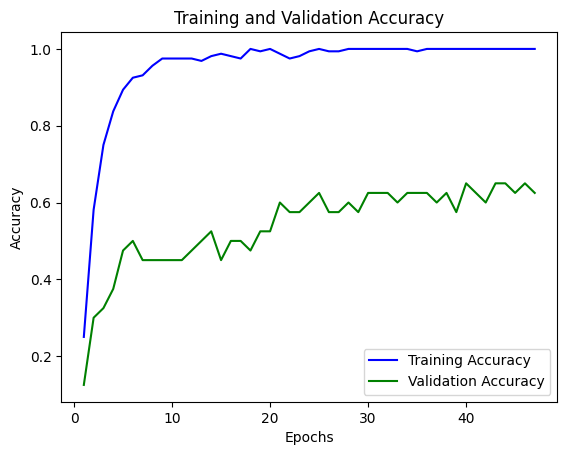


# Evaluate on test data
200/200 [==============================] - 1s 5ms/step - loss: 1.0324 - accuracy: 0.4850
Test loss, Test accuracy: [1.032435417175293, 0.48500001430511475]
7/7 [==============================] - 1s 35ms/step
AUC Accuracy Score: 0.7937666666666666



Current kl: 16
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38583, saving model to /tmp/checkpoint.h5
10/10 - 3s - loss: 1.3840 - accuracy: 0.2688 - val_loss: 1.3858 - val_accuracy: 0.1500 - 3s/epoch - 309ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.38583 to 1.38345, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2552 - accuracy: 0.5188 - val_loss: 1.3835 - val_accuracy: 0.2250 - 544ms/epoch - 54ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.38345 to 1.38089, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.1342 - accuracy: 0.6938 - val_loss: 1.3809 - val_accuracy: 0.2250 - 539ms/epoch - 54ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.38089 to 1.37

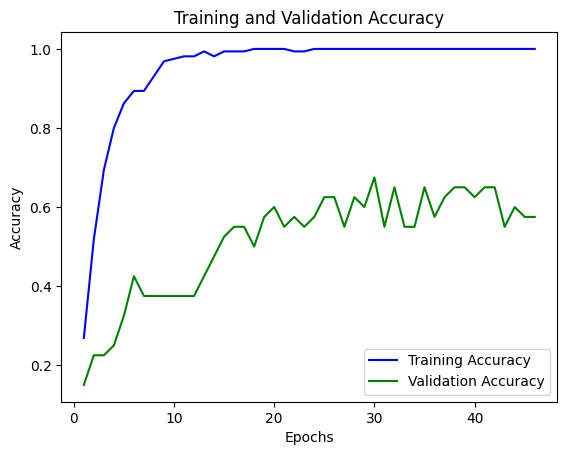


# Evaluate on test data
200/200 [==============================] - 1s 5ms/step - loss: 1.0927 - accuracy: 0.4900
Test loss, Test accuracy: [1.0927406549453735, 0.49000000953674316]
7/7 [==============================] - 0s 44ms/step
AUC Accuracy Score: 0.7876666666666667



Current kl: 16
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38957, saving model to /tmp/checkpoint.h5
10/10 - 3s - loss: 1.3981 - accuracy: 0.3313 - val_loss: 1.3896 - val_accuracy: 0.0750 - 3s/epoch - 322ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.38957 to 1.38866, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.3091 - accuracy: 0.4187 - val_loss: 1.3887 - val_accuracy: 0.1250 - 608ms/epoch - 61ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.38866 to 1.38686, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2601 - accuracy: 0.5625 - val_loss: 1.3869 - val_accuracy: 0.2000 - 637ms/epoch - 64ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.38686 to 1.38

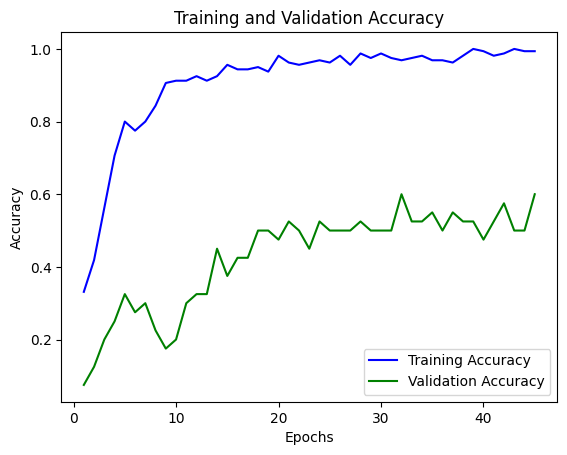


# Evaluate on test data
200/200 [==============================] - 1s 5ms/step - loss: 1.1761 - accuracy: 0.4300
Test loss, Test accuracy: [1.1761224269866943, 0.4300000071525574]
7/7 [==============================] - 1s 59ms/step
AUC Accuracy Score: 0.7641333333333333



Current kl: 32
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38689, saving model to /tmp/checkpoint.h5
10/10 - 4s - loss: 1.4126 - accuracy: 0.2875 - val_loss: 1.3869 - val_accuracy: 0.3000 - 4s/epoch - 444ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.38689 to 1.38447, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2300 - accuracy: 0.6313 - val_loss: 1.3845 - val_accuracy: 0.4000 - 574ms/epoch - 57ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.38447 to 1.37941, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.1297 - accuracy: 0.7312 - val_loss: 1.3794 - val_accuracy: 0.4750 - 572ms/epoch - 57ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.37941 to 1.369

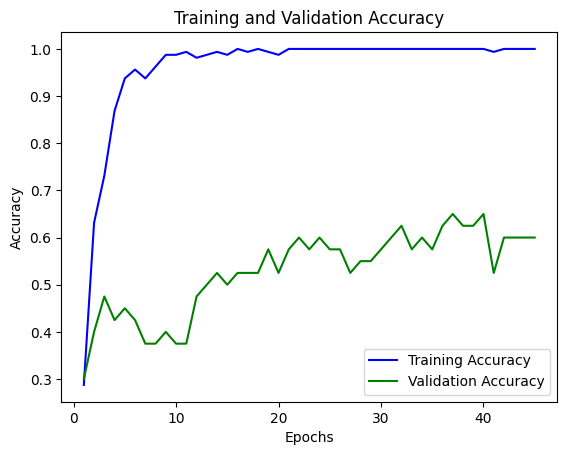


# Evaluate on test data
200/200 [==============================] - 1s 5ms/step - loss: 1.0545 - accuracy: 0.4900
Test loss, Test accuracy: [1.0544865131378174, 0.49000000953674316]
7/7 [==============================] - 1s 36ms/step
AUC Accuracy Score: 0.7971999999999999



Current kl: 32
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38653, saving model to /tmp/checkpoint.h5
10/10 - 3s - loss: 1.4240 - accuracy: 0.2313 - val_loss: 1.3865 - val_accuracy: 0.2250 - 3s/epoch - 321ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.38653 to 1.38458, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2946 - accuracy: 0.4500 - val_loss: 1.3846 - val_accuracy: 0.3250 - 647ms/epoch - 65ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.38458 to 1.38171, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2046 - accuracy: 0.7250 - val_loss: 1.3817 - val_accuracy: 0.3250 - 576ms/epoch - 58ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.38171 to 1.3

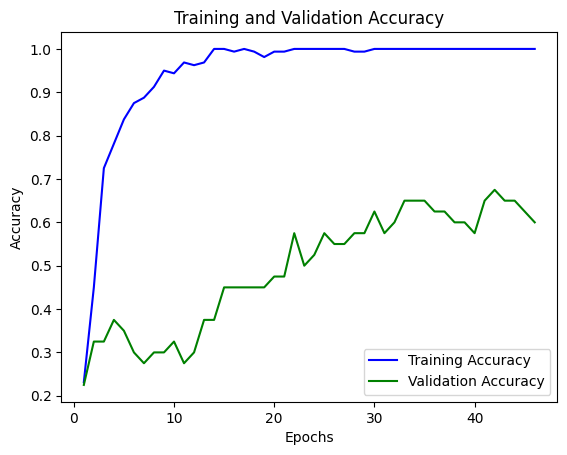


# Evaluate on test data
200/200 [==============================] - 1s 5ms/step - loss: 1.0354 - accuracy: 0.4950
Test loss, Test accuracy: [1.0353689193725586, 0.4950000047683716]
7/7 [==============================] - 1s 49ms/step
AUC Accuracy Score: 0.7995333333333333



Current kl: 32
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38447, saving model to /tmp/checkpoint.h5
10/10 - 4s - loss: 1.4081 - accuracy: 0.2688 - val_loss: 1.3845 - val_accuracy: 0.3750 - 4s/epoch - 386ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.38447 to 1.38294, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.3230 - accuracy: 0.3812 - val_loss: 1.3829 - val_accuracy: 0.3750 - 591ms/epoch - 59ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.38294 to 1.38028, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2634 - accuracy: 0.5188 - val_loss: 1.3803 - val_accuracy: 0.3250 - 585ms/epoch - 58ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.38028 to 1.374

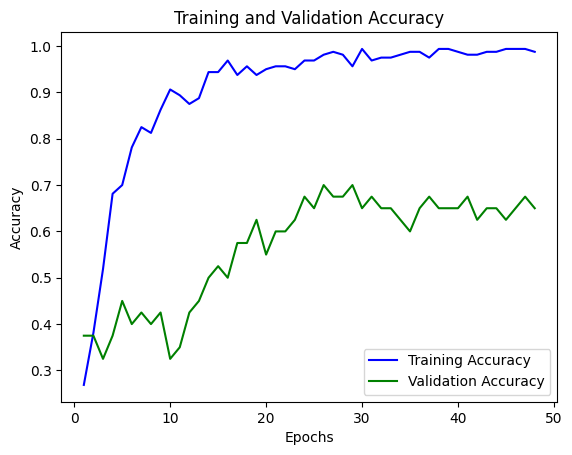


# Evaluate on test data
200/200 [==============================] - 1s 5ms/step - loss: 1.0169 - accuracy: 0.5200
Test loss, Test accuracy: [1.0168765783309937, 0.5199999809265137]
7/7 [==============================] - 0s 42ms/step
AUC Accuracy Score: 0.8099333333333333



Current kl: 64
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38664, saving model to /tmp/checkpoint.h5
10/10 - 4s - loss: 1.4007 - accuracy: 0.2062 - val_loss: 1.3866 - val_accuracy: 0.2000 - 4s/epoch - 400ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.38664 to 1.38659, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2278 - accuracy: 0.6125 - val_loss: 1.3866 - val_accuracy: 0.1750 - 611ms/epoch - 61ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.38659 to 1.38449, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.0928 - accuracy: 0.8062 - val_loss: 1.3845 - val_accuracy: 0.2000 - 689ms/epoch - 69ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.38449 to 1.380

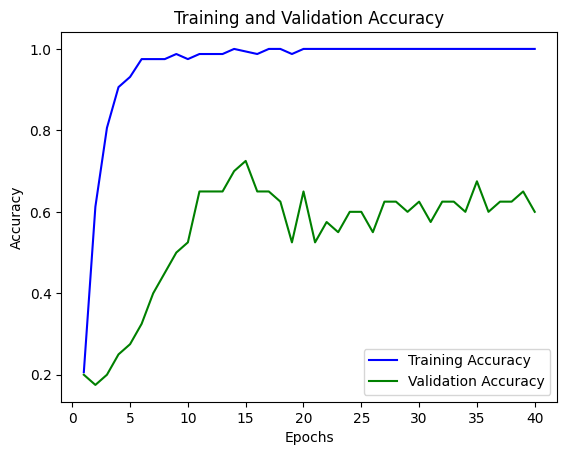


# Evaluate on test data
200/200 [==============================] - 1s 5ms/step - loss: 1.0664 - accuracy: 0.5450
Test loss, Test accuracy: [1.0664387941360474, 0.5450000166893005]
7/7 [==============================] - 1s 47ms/step
AUC Accuracy Score: 0.7979666666666667



Current kl: 64
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38345, saving model to /tmp/checkpoint.h5
10/10 - 6s - loss: 1.4223 - accuracy: 0.2375 - val_loss: 1.3834 - val_accuracy: 0.2750 - 6s/epoch - 577ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.38345 to 1.37994, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2275 - accuracy: 0.5625 - val_loss: 1.3799 - val_accuracy: 0.2750 - 618ms/epoch - 62ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.37994 to 1.37343, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.0881 - accuracy: 0.7437 - val_loss: 1.3734 - val_accuracy: 0.3500 - 696ms/epoch - 70ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.37343 to 1.35

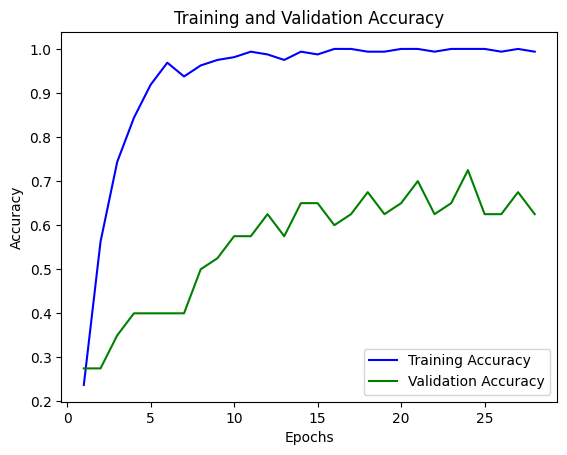


# Evaluate on test data
200/200 [==============================] - 2s 7ms/step - loss: 0.9973 - accuracy: 0.5550
Test loss, Test accuracy: [0.9973323941230774, 0.5550000071525574]
7/7 [==============================] - 1s 71ms/step
AUC Accuracy Score: 0.8114333333333332



Current kl: 64
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38676, saving model to /tmp/checkpoint.h5
10/10 - 3s - loss: 1.3971 - accuracy: 0.2875 - val_loss: 1.3868 - val_accuracy: 0.2250 - 3s/epoch - 330ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.38676 to 1.38675, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.3282 - accuracy: 0.3938 - val_loss: 1.3868 - val_accuracy: 0.2250 - 625ms/epoch - 63ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.38675 to 1.38555, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2726 - accuracy: 0.4750 - val_loss: 1.3855 - val_accuracy: 0.2750 - 699ms/epoch - 70ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.38555 to 1.382

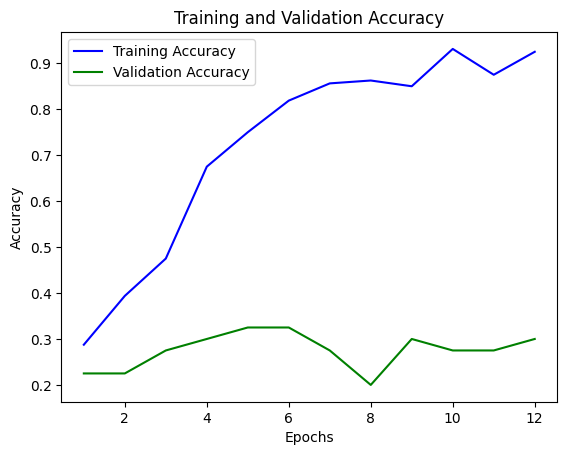


# Evaluate on test data
200/200 [==============================] - 1s 6ms/step - loss: 1.3267 - accuracy: 0.3450
Test loss, Test accuracy: [1.3267064094543457, 0.3449999988079071]
7/7 [==============================] - 1s 63ms/step
AUC Accuracy Score: 0.6382333333333333



Current kl: 128
Current d: 0.2

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38678, saving model to /tmp/checkpoint.h5
10/10 - 4s - loss: 1.4164 - accuracy: 0.2313 - val_loss: 1.3868 - val_accuracy: 0.1750 - 4s/epoch - 443ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.38678 to 1.38214, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2505 - accuracy: 0.5312 - val_loss: 1.3821 - val_accuracy: 0.4000 - 796ms/epoch - 80ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.38214 to 1.37803, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.1400 - accuracy: 0.7375 - val_loss: 1.3780 - val_accuracy: 0.3750 - 801ms/epoch - 80ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.37803 to 1.37

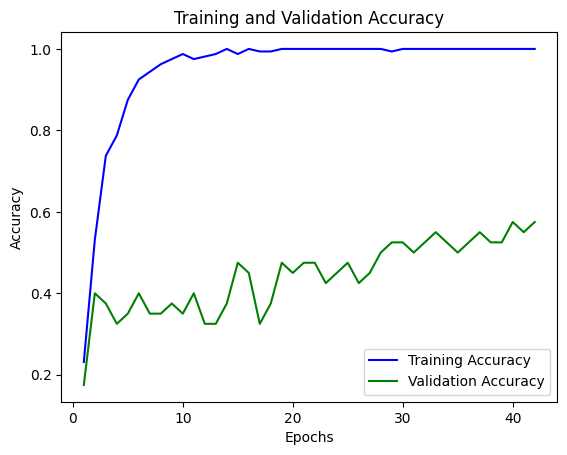


# Evaluate on test data
200/200 [==============================] - 1s 6ms/step - loss: 0.9695 - accuracy: 0.5850
Test loss, Test accuracy: [0.9695104956626892, 0.5849999785423279]
7/7 [==============================] - 1s 41ms/step
AUC Accuracy Score: 0.8352666666666666



Current kl: 128
Current d: 0.25

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38466, saving model to /tmp/checkpoint.h5
10/10 - 5s - loss: 1.3962 - accuracy: 0.2750 - val_loss: 1.3847 - val_accuracy: 0.2500 - 5s/epoch - 455ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.38466 to 1.37958, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2104 - accuracy: 0.6125 - val_loss: 1.3796 - val_accuracy: 0.4000 - 732ms/epoch - 73ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.37958 to 1.36816, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.0761 - accuracy: 0.7500 - val_loss: 1.3682 - val_accuracy: 0.4500 - 792ms/epoch - 79ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.36816 to 1.3

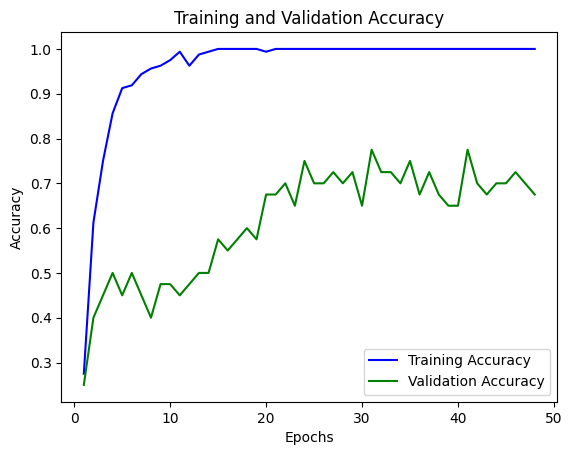


# Evaluate on test data
200/200 [==============================] - 1s 6ms/step - loss: 1.3575 - accuracy: 0.4050
Test loss, Test accuracy: [1.3575283288955688, 0.4050000011920929]
7/7 [==============================] - 0s 46ms/step
AUC Accuracy Score: 0.7276666666666666



Current kl: 128
Current d: 0.5

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38203, saving model to /tmp/checkpoint.h5
10/10 - 3s - loss: 1.4149 - accuracy: 0.2625 - val_loss: 1.3820 - val_accuracy: 0.4000 - 3s/epoch - 330ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.38203 to 1.37599, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2864 - accuracy: 0.4938 - val_loss: 1.3760 - val_accuracy: 0.4250 - 723ms/epoch - 72ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.37599 to 1.36553, saving model to /tmp/checkpoint.h5
10/10 - 1s - loss: 1.2099 - accuracy: 0.5437 - val_loss: 1.3655 - val_accuracy: 0.5000 - 725ms/epoch - 72ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.36553 to 1.35

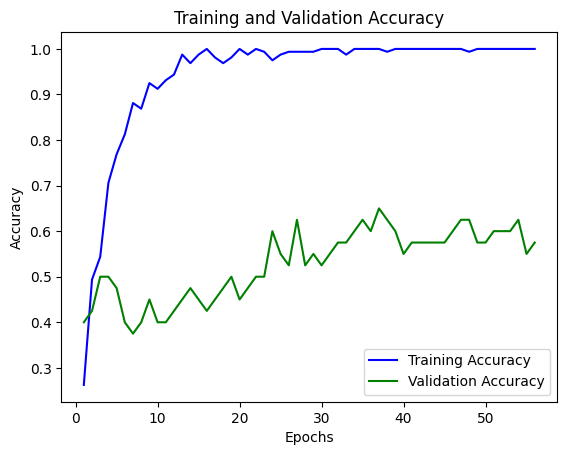


# Evaluate on test data
200/200 [==============================] - 1s 5ms/step - loss: 1.2285 - accuracy: 0.4450
Test loss, Test accuracy: [1.2284663915634155, 0.4449999928474426]
7/7 [==============================] - 1s 57ms/step
AUC Accuracy Score: 0.7618


Highest AUC Score: 0.8352666666666666
Best kl value: 128
Best d value: 0.2


<ipython-input-8-b141d0f0f27f>:111: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Event Pair': 'All Classes', 'AUC Score': highest_auc_score, 'kl': best_kl, 'd': best_d}, ignore_index=True)


    Event Pair  AUC Score   kl    d
0  All Classes   0.835267  128  0.2


In [8]:
# Assign X_train, y_train, X_test, and y_test variables for all event IDs
X_train = epochs_train.get_data()
y_train = epochs_train.events[:, -1]
X_test = epochs_test.get_data()
y_test = epochs_test.events[:, -1]

# Shuffle the training set
X_train, y_train = shuffle(X_train, y_train)

# Compute mean and standard deviation of the training data
train_mean = np.mean(X_train)
train_std = np.std(X_train)

# Normalize the training data
X_train = (X_train - train_mean) / train_std

# Normalize the testing data using the mean and standard deviation of the training data
X_test = (X_test - train_mean) / train_std

# Reshape the data to match EEGNet input format
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

# Convert labels to one-hot encodings
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

# Update the nb_classes parameter in the EEGNet function
nb_classes = y_train.shape[1]
print()
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print()

# Initialize variables to store the highest AUC score and corresponding kl and d values
highest_auc_score = 0
best_kl = None
best_d = None

# Iterate over the kl and d values
for kl in kl_values:
    for d in d_values:
        print()
        print("Current kl:", kl)
        print("Current d:", d)
        print()

        # Configure the EEGNet model
        model = EEGNet(nb_classes=nb_classes, Chans=X_train.shape[2], Samples=X_train.shape[3], dropoutRate=d, kernLength=kl)

        # Compile the model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Set a valid path for model checkpoints
        checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

        # Class weights
        class_weights = {0: 1, 1: 1, 2: 1, 3: 1}

        # Fit the model to the training data
        history = model.fit(X_train, y_train, batch_size=16, epochs=n_epochs, verbose=2,
                            validation_split=0.2, callbacks=[checkpointer, EarlyStopping(patience=5)], class_weight=class_weights)

        # Access the accuracy values from the history object
        train_accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']

        # Plot the training and validation accuracy
        epochs = range(1, len(train_accuracy) + 1)
        plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
        plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        print('\n# Evaluate on test data')
        results = model.evaluate(X_test, y_test, batch_size=1)
        print('Test loss, Test accuracy:', results)

        # Evaluate the model on the test data
        y_pred = model.predict(X_test)
        auc_score = roc_auc_score(y_test, y_pred)
        # Print the AUC accuracy score
        print('AUC Accuracy Score:', auc_score)

        # Check if the current AUC score is higher than the highest recorded score
        if auc_score > highest_auc_score:
            highest_auc_score = auc_score
            best_kl = kl
            best_d = d

        # Reset the Keras session to clear the model
        K.clear_session()

        print()
        print('=' * 100)
        print('=' * 100)
        print()

# Print the highest AUC score and the corresponding kl and d values
print("Highest AUC Score:", highest_auc_score)
print("Best kl value:", best_kl)
print("Best d value:", best_d)

# Append the results to the DataFrame
results_df = results_df.append({'Event Pair': 'All Classes', 'AUC Score': highest_auc_score, 'kl': best_kl, 'd': best_d}, ignore_index=True)

# Save the highest AUC score and the corresponding kl and d values to a file
np.save(out_f_name, {'auc_score': highest_auc_score, 'kl_value': best_kl, 'd_value': best_d})

# Print the final results table
print(results_df)